# Notebook to compute the LSST's passbands and the impact of the atmospheric parameters on the colors of reference sources 

In this notebook we are going to take the reference spectra from the pysynphot's spectral atlases and make them pass through the LSST's throughput and the simulated atmospheres from the previous notebooks. 

This notebook requires [pysynphot](https://pysynphot.readthedocs.io/en/latest/) 


# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from scipy import integrate
from astropy.io import fits
#import quadpy

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


# Define LaTeX commands 

$\newcommand{\AA}{\mathit{\unicode{x212B}}}$
Angstrom symbol: $\AA$

# Set LSST's parameters 

In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Set wavelength units 

In [5]:
waveunits = 'angstrom'
wavelabel = r'$\AA$'

# Define general paths 

In [6]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [7]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


# Select a spectral atlas 

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [8]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [9]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

,File,Type,Teff,Name
0,pickles_uk_1.fits,O5V,39810.70,unknown
1,pickles_uk_2.fits,O9V,35481.40,unknown
2,pickles_uk_3.fits,B0V,28183.80,unknown
3,pickles_uk_4.fits,B1V,22387.20,unknown
4,pickles_uk_5.fits,B3V,19054.60,unknown
...,...,...,...,...
126,pickles_uk_127.fits,G8I,4591.98,unknown
127,pickles_uk_128.fits,K2I,4255.98,unknown
128,pickles_uk_129.fits,K3I,NaN,unknown
129,pickles_uk_130.fits,K4I,3990.25,unknown


# Load with pysynphot the spectra from the selected atlas 

In [10]:
sed_list = np.array(atlas_seds['File'])

In [11]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    assert str(spec_.waveunits)==waveunits
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

# Define also the spectral types 

In [12]:
spectral_types = ['O','B','A','F','G','K','M']

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

# Organise spectra by spectral type 

In [13]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [14]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

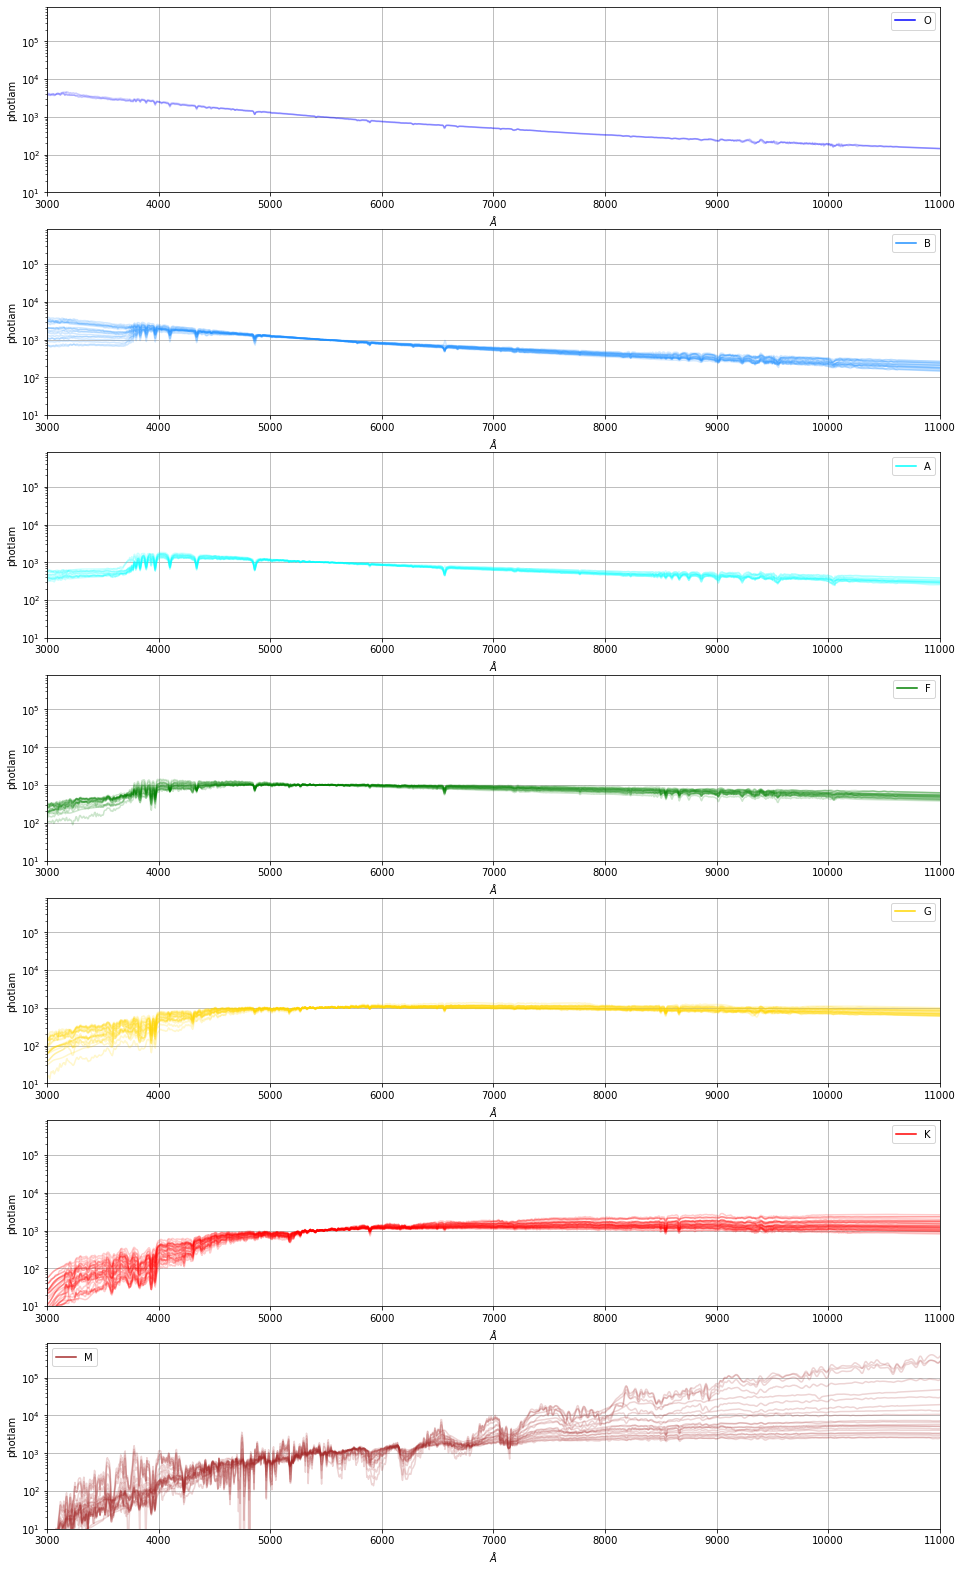

In [15]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(wavelabel)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,820000)
    axs[row].set_yscale("log")
            

# Now we assign an ID to each object and we also classify these IDs by spectral type 

In [16]:
id_dict = {}
for i,sed in enumerate(sed_list):
    id_dict[sed[:-5]] = '{0}'.format(i+1).zfill(len(str(len(sed_list))))

In [17]:
id_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    id_list_ = []
    id_by_type[spec_type] = []
    for sed_ in id_dict.keys():
        if spec_type in type_dict[sed_]:
            id_list_.append(id_dict[sed_])
            id_by_type[spec_type].append(sed_)
    print(spec_type, id_list_)
    print(len(id_list_))
    print('-----------')

O ['001', '002', '060']
3
-----------
B ['003', '004', '005', '006', '007', '008', '046', '047', '061', '062', '063', '064', '106', '107', '114', '115', '116', '117', '118']
19
-----------
A ['009', '010', '011', '012', '013', '048', '049', '065', '066', '067', '068', '119', '120']
13
-----------
F ['014', '015', '016', '017', '018', '019', '020', '021', '022', '050', '051', '052', '069', '070', '071', '108', '109', '121', '122', '123']
20
-----------
G ['023', '024', '025', '026', '027', '028', '029', '030', '053', '054', '055', '056', '072', '073', '074', '075', '076', '077', '110', '124', '125', '126', '127']
23
-----------
K ['031', '032', '033', '034', '035', '036', '037', '057', '058', '059', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '111', '112', '128', '129', '130']
32
-----------
M ['038', '039', '040', '041', '042', '043', '044', '045', '095', '096', '097', '098', '099', '100', '101', '102', '103', '

# Load LSST's throughput 

https://github.com/lsst/throughputs/tree/main/baseline

In [18]:
throughput_path = 'data/lsst/'
throughput_label = 'hardware_{0}.dat'

In [19]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

Write the throughputs in pysynphot format 

In [20]:
lsst_bp = []
for i,f in enumerate(filters):
    throughput_ = np.loadtxt(throughput_path+throughput_label.format(f.lower()))
    wl_ = throughput_[:,0]*10.
    lsst_bp.append(S.ArrayBandpass(wl_, throughput_[:,1] , name=f))
    assert str(lsst_bp[i].waveunits)==waveunits


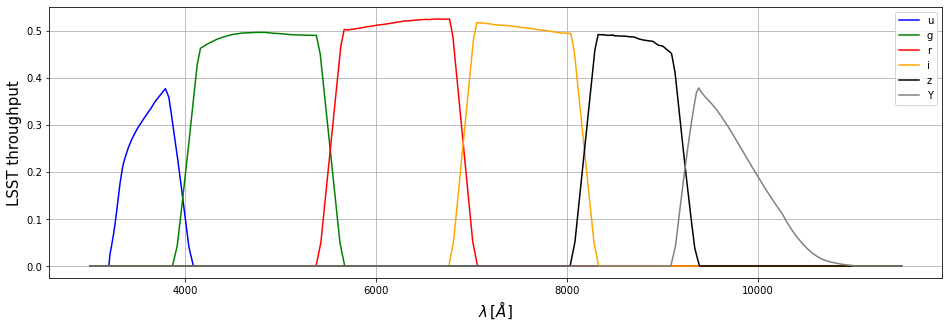

In [21]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

In [22]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [23]:
wl_lsst = lsst_bp[0].wave

For each filter we can define the effective wavelength, $\lambda_b^{eff}$, as 

$$\lambda_b^{eff} = \frac{\int \lambda \, T_{tel,b}(\lambda) \, d\lambda}{\int T_{tel,b}(\lambda) \, d\lambda} \, . $$

In [24]:
def calc_eff_lambda(T):
    assert (np.isnan(T.throughput)==True).any()==False
    
    wl_ = T.wave
    trans_ = T.throughput
    
    num_ = np.trapz(wl_*trans_,x=wl_)
    den_ = np.trapz(trans_,x=wl_)
    
    return num_/den_

In [25]:
eff_lambda = {}
eff_lambda_vec = []
for i,filter in enumerate(filters):
    eff_l_ = calc_eff_lambda(lsst_bp[i])
    eff_lambda[filter] = eff_l_
    eff_lambda_vec.append(eff_l_)
    print(calc_eff_lambda(lsst_bp[i]))
eff_lambda_vec = np.array(eff_lambda_vec)

3646.6653725477827
4775.689949910929
6221.858748950202
7538.742212119657
8695.989905566856
9703.26518629804


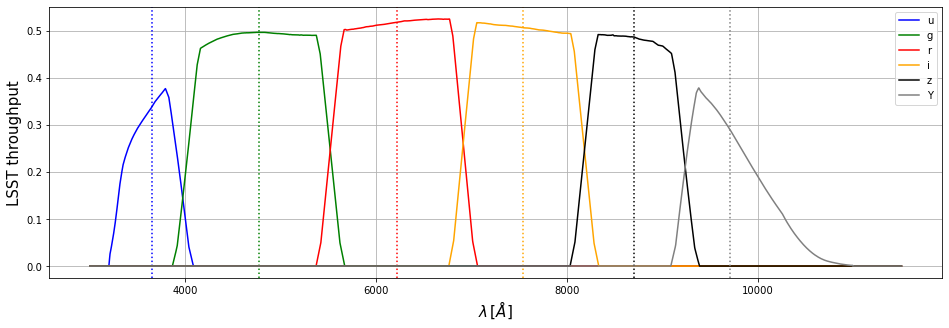

In [26]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [27]:
variable_param = 'pwv'
am0 = 1.2
cloud0 = 0.0
pwv0 = 3.0
aero0 = 0.04

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [28]:
param_dist = 'linear_distribution-discrete'

In [29]:
outdir_plots_ = os.path.join('output_plots/',param_dist.split('-')[0])
if os.path.exists(outdir_plots_)==False:
    os.mkdir(outdir_plots_)

outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [30]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [31]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [32]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [33]:
wl_t = data[0][n_atmp:]*10.

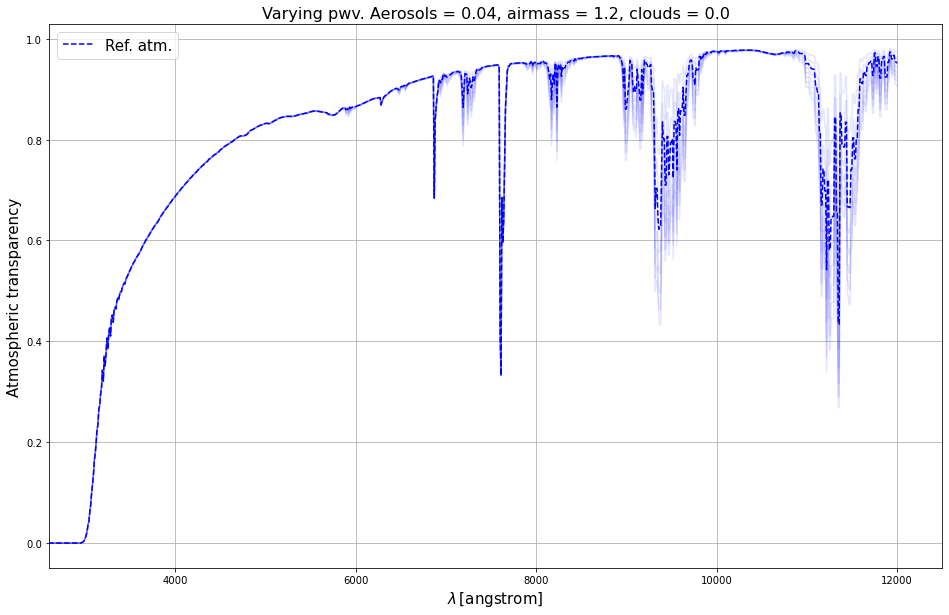

In [34]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of values of variable parameter 

In [35]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [36]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [37]:
var_index = params_index[variable_param]

In [38]:
#data[1:,1]
data[1:,var_index]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Select data for variable parameter of these simulations 

In [39]:
atm_vals = data[1:,var_index]

In [40]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [41]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    assert str(atm_i.waveunits)==waveunits
    atm_transp.append(atm_i)

In [42]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))
assert str(atm_transp_ref.waveunits)==waveunits

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [43]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [44]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [45]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(u * Atm. transp. 1)


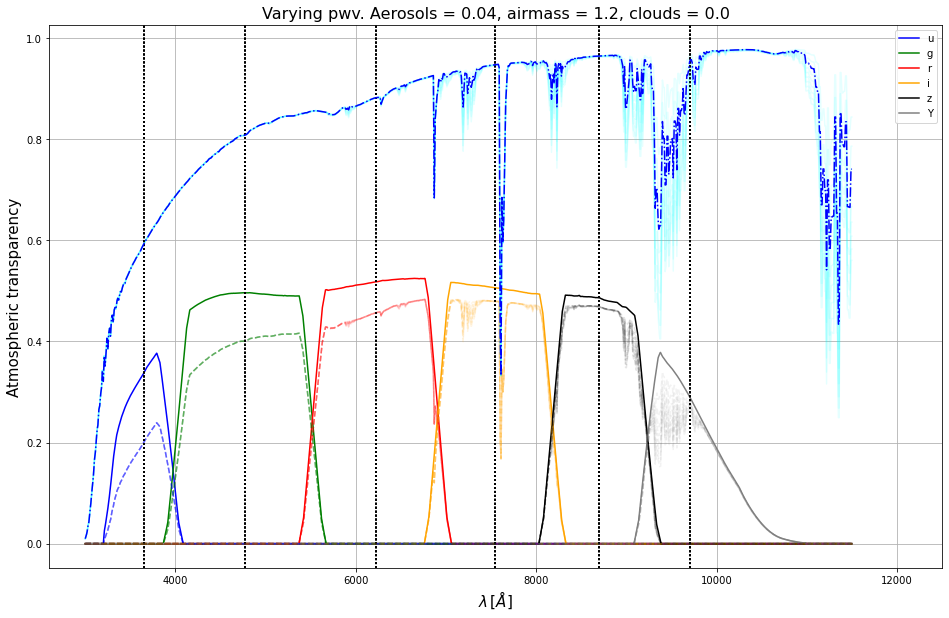

In [46]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
        ax.axvline(x=eff_lambda[bpname],ls=':',color='k')
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [47]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

1.0 9.0


In [48]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [49]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

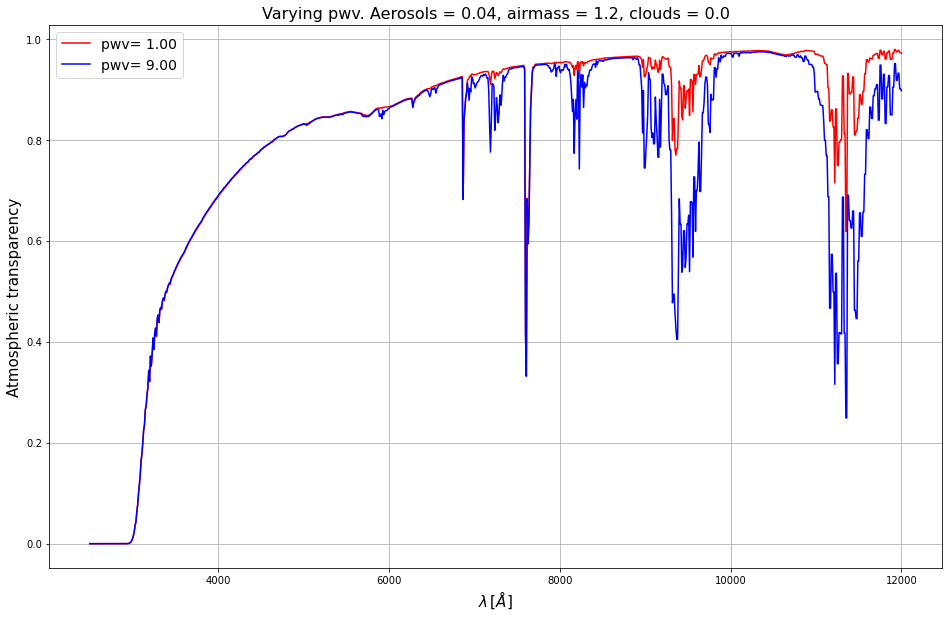

In [50]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [51]:
id_by_type

{'O': ['pickles_uk_1', 'pickles_uk_2', 'pickles_uk_60'],
 'B': ['pickles_uk_3',
  'pickles_uk_4',
  'pickles_uk_5',
  'pickles_uk_6',
  'pickles_uk_7',
  'pickles_uk_8',
  'pickles_uk_46',
  'pickles_uk_47',
  'pickles_uk_61',
  'pickles_uk_62',
  'pickles_uk_63',
  'pickles_uk_64',
  'pickles_uk_106',
  'pickles_uk_107',
  'pickles_uk_114',
  'pickles_uk_115',
  'pickles_uk_116',
  'pickles_uk_117',
  'pickles_uk_118'],
 'A': ['pickles_uk_9',
  'pickles_uk_10',
  'pickles_uk_11',
  'pickles_uk_12',
  'pickles_uk_13',
  'pickles_uk_48',
  'pickles_uk_49',
  'pickles_uk_65',
  'pickles_uk_66',
  'pickles_uk_67',
  'pickles_uk_68',
  'pickles_uk_119',
  'pickles_uk_120'],
 'F': ['pickles_uk_14',
  'pickles_uk_15',
  'pickles_uk_16',
  'pickles_uk_17',
  'pickles_uk_18',
  'pickles_uk_19',
  'pickles_uk_20',
  'pickles_uk_21',
  'pickles_uk_22',
  'pickles_uk_50',
  'pickles_uk_51',
  'pickles_uk_52',
  'pickles_uk_69',
  'pickles_uk_70',
  'pickles_uk_71',
  'pickles_uk_108',
  'pickles_

In [52]:
# Example with one spectrum 
example_id = 'pickles_uk_103'
#example_id = 'pickles_uk_1'
example_spec = sed_dict[example_id]
example_wl = sed_dict[example_id].wave
example_type = 'M'
print(example_spec,example_id)

/home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/grid/pickles/dat_uvk/pickles_uk_103.fits pickles_uk_103


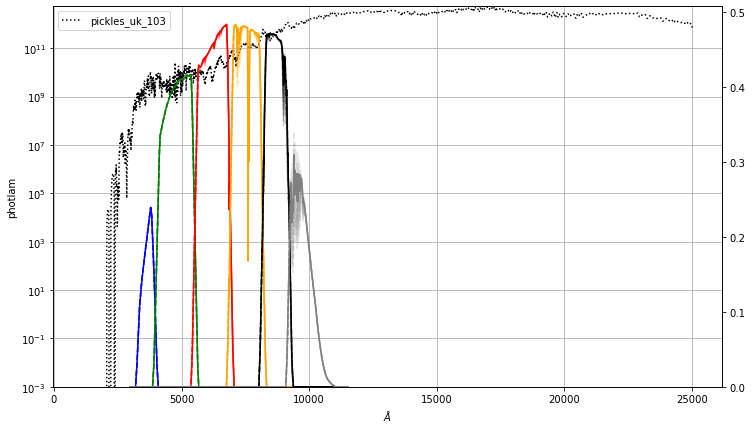

In [53]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',label=example_id)
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    for isim in range(n_sim):
        ax2.plot(total_passband[filter][isim].wave,total_passband[filter][isim].throughput,ls='--',color=filter_colors[i],alpha=0.2)
    
#ax.set_xlim(9500.,9900.)
ax.set_ylim(0.001,)
ax2.set_ylim(0.,)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel(wavelabel)
ax.set_ylabel(example_spec.fluxunits)
ax.legend()

In [54]:
obs_flux_t_dict = {}
obs_flux_std_dict = {}


for filter in filters:
    obs_flux_t_dict[filter] = []

for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal_ = S.Observation(example_spec,total_passband[filter][i],force='taper')
        obs_flux_t_dict[filter].append(obstotal_)

for filter in filters:
    obs_flux_std_dict[filter] = S.Observation(example_spec,total_passband_ref[filter],force='taper')



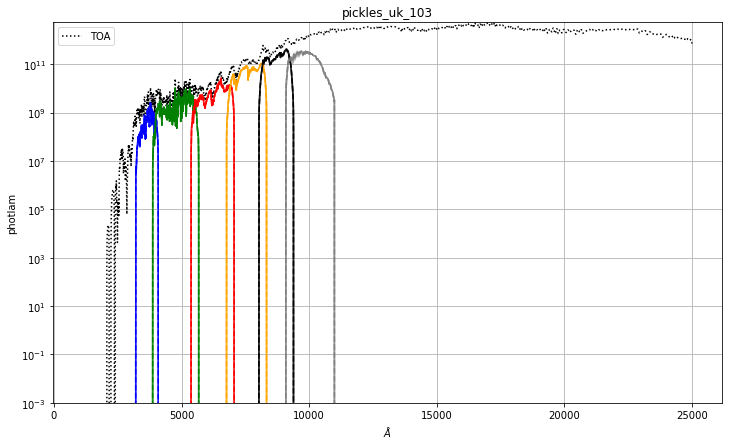

In [55]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA')

for i,filter in enumerate(filters):
    ax.plot(obs_flux_std_dict[filter].wave,obs_flux_std_dict[filter].flux*Seff*exptime,ls='--',color=filter_colors[i])
    
    for isim in range(n_sim):
        ax.plot(obs_flux_t_dict[filter][isim].wave,obs_flux_t_dict[filter][isim].flux*Seff*exptime,ls='-',color=filter_colors[i],alpha=0.2)
    
ax.set_ylim(0.001,)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel(wavelabel)
ax.set_ylabel(example_spec.fluxunits)
ax.set_title(example_id)
ax.legend()

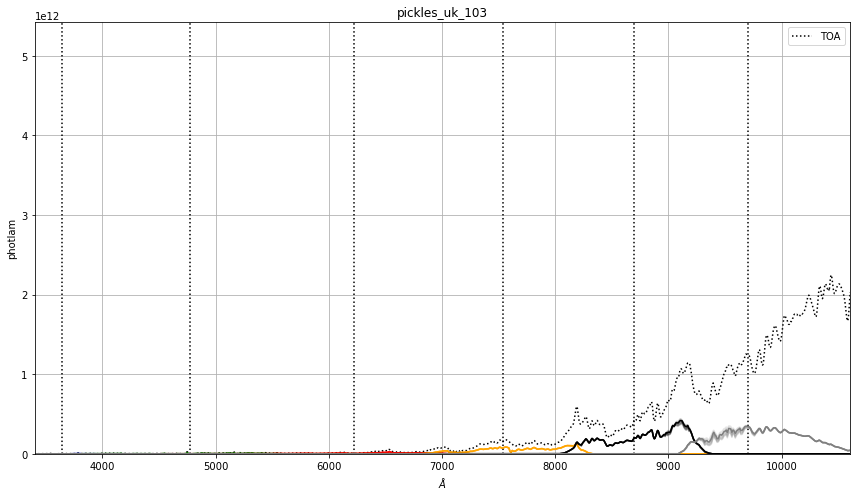

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA')

for i,filter in enumerate(filters):
    ax.plot(obs_flux_std_dict[filter].wave,obs_flux_std_dict[filter].flux*Seff*exptime,ls='-',color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color='k')
    
    for isim in range(n_sim):
        ax.plot(obs_flux_t_dict[filter][isim].wave,obs_flux_t_dict[filter][isim].flux*Seff*exptime,ls='-',color=filter_colors[i],alpha=0.2)
    
ax.set_xlim(WLMIN,WLMAX)
ax.set_ylim(0.001,)
#ax.set_yscale("log")
ax.grid()
ax.set_xlabel(wavelabel)
ax.set_ylabel(example_spec.fluxunits)
ax.set_title(example_id)
ax.legend()
plt.tight_layout()

In [57]:
8.03e11*0.27

216810000000.0

# Calculate magnitudes with our own function 

Physical constants 

In [58]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [59]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [60]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [61]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [62]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

We check that this function actually creates a spectrum with the properties of an AB source, that is, a flat spectrum in fnu units (erg/s/cm2/Hz) 

Text(0, 0.5, 'Flux [Jy]')

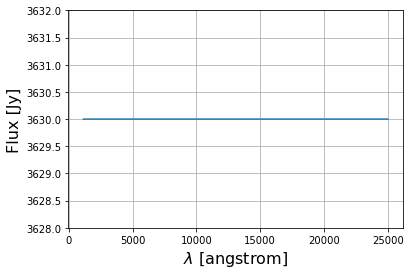

In [63]:
checkab = ABnphot(example_spec.wave)
checkab_ = S.ArraySpectrum(example_spec.wave, checkab, name='Flat AB spectrum')
#plt.plot(checkab_.wave,checkab_.flux)
checkab_.convert('fnu')
plt.plot(checkab_.wave,checkab_.flux*10**23.)
plt.ylim(3.628*10.**3,3.632*10**3.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel('Flux [Jy]',fontsize=16)

Now, we define our function to compute the AB magnitudes: 

$$m_{AB} = -2.5 \log_{10} \frac{\int F_{\nu}^E(\lambda) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda) \frac{d\lambda}{h \lambda}}{\int F_{\nu, AB}^E \cdot S_{eff} \cdot t_{exp} \cdot S_{throughput}(\lambda) \frac{d\lambda}{h \lambda}} = -2.5 \log_{10} \frac{\varphi}{\Phi_{AB}} \, . $$ 

Now, we want to compute the error for the AB magnitudes. The denominator is constant for a given $S_{throughput}(\lambda)$, so we assume it does not contribute to the error. Then, we can approximate $\varphi$ as 

$$\varphi \approx \sum_i F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda_i) \frac{\Delta \lambda_i}{h \lambda_i} = \sum_i n_i \cdot S_{passband}(\lambda_i) \cdot \Delta \lambda_i \, , $$ 

where $n_i$ is 

$$n_i = \frac{F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp}}{h \lambda_i} \, ,$$

the number of photo-electrons received within a given bin of wavelength, $\Delta \lambda_i$. Then, we can assume that $n_i$ is a Poisson random variable, so 

$$\sigma^2_{n_i} = n_i . $$ 

Taking this into account, we can write the error of $\varphi$ as 

$$\sigma^2_{\varphi} = \sum_i \left( \frac{\partial \varphi}{\partial n_i} \right)^2 \sigma^2_{n_i} = \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, , $$ 

Finally, the error on $m_{AB}$ is given by 
$$\sigma^2_{m_{AB}} = \left( \frac{\partial m_{AB}}{\partial \varphi} \right)^2 \sigma^2_{\varphi} = \left( \frac{-2.5}{\varphi \log 10} \right)^2 \cdot \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, . $$ 


In [64]:
def int_flux(spec,passband,filter=None,return_mag=False,return_error=False,
             PhiAB=None,renormalize=None,verbose=False):
    f_units = str(spec.fluxunits)
    if f_units!='fnu':
        if verbose:
            print('ATTENTION: converting flux units to fnu')
        spec.convert('fnu')
        
    observation = S.Observation(spec,passband,force='taper')
    if verbose:
        print('Observation units = ', observation.fluxunits)
    nan_mask = np.isnan(observation.flux)
    
    obs_wave_ = observation.wave[~nan_mask]
    obs_flux_ = observation.flux[~nan_mask]
    wave_min = np.min(observation.wave[~nan_mask])
    wave_max = np.max(observation.wave[~nan_mask])
    
    if renormalize!=None:
        renorm = np.power(10.,-1.*renormalize/2.5)
    else:
        renorm = 1.0
    
    num = np.trapz(obs_flux_*renorm/obs_wave_,x=obs_wave_)*Seff*exptime/h_planck
    
    if return_error:
        finterp_pb = interp1d(passband.wave,passband.throughput,bounds_error=False,fill_value=0.)
        pb_interp = finterp_pb(spec.wave)
        
        delta_lambda = list(np.diff(spec.wave))
        delta_lambda.append(spec.wave[-1]-spec.wave[-2])
        delta_lambda = np.array(delta_lambda)
        assert len(delta_lambda)==len(spec.wave)
        
        assert str(spec.fluxunits)=='fnu'
        n_i = spec.flux*renorm*Seff*exptime/(spec.wave*h_planck)
        print('n_i = ', n_i)
        #print('Number of collected photoelectrons = {0:.2e}'.format(np.sum(n_i*pb_interp)))
        err2_num = np.sum(n_i*(np.array(pb_interp)*delta_lambda)**2.)
    
    spec.convert(f_units)
    
    if verbose:
        print('Numerator = {0:.2e}'.format(num))
    if return_error and verbose:
        print('Variance of the numerator = {0:.2e}'.format(err2_num))
    
    if return_mag:
        
        if PhiAB is None:
            assert filter is not None
            flatsp_nphot = ABnphot(spec.wave)
            flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')

            flatsp_.convert('fnu')
            ab_obs = S.Observation(flatsp_,filter,force='taper')
            if verbose:
                print('AB observation units = ', ab_obs.fluxunits)

            ab_wave_ = ab_obs.wave[~nan_mask]
            ab_flux_ = ab_obs.flux[~nan_mask]

            den = np.trapz(ab_flux_/ab_wave_,x=ab_wave_)*Seff*exptime/h_planck
        else:
            den = PhiAB
            if verbose:
                print('ATTENTION: using external Phi_AB. Not computing it')

        if verbose:
            print('Denominator = {0:.2e}'.format(den))
        mab = -2.5*np.log10(num/den)
        if verbose:
            print('AB magnitude = ', mab)
            print('---------')
    
    if return_mag==False:
        if return_error:
            return num,np.sqrt(err2_num)
        else:
            return num
    else:
        if return_error:
            err2_mab = (2.5**2./np.log(10.)**2.)*err2_num/num**2.
            err_mab = np.sqrt(err2_mab)
            return num,mab,np.sqrt(err2_num),err_mab
        else:
            return num,mab
    

To avoid computing $\Phi_{AB}$ each time, we define that integral once and we give it to our function each time it is needed 

In [65]:
flatsp_nphot = ABnphot(example_spec.wave)

In [66]:
flat_spec = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [67]:
Phi_AB = []
for filter in lsst_bp:
    Phi_AB_b = int_flux(flat_spec,filter)
    Phi_AB.append(Phi_AB_b)
    print(Phi_AB_b)
Phi_AB = np.array(Phi_AB)

3088398409927.2
8219719263298.365
6160614701335.237
4552583446697.673
3081715818183.534
1647819206182.2043


In [68]:
for filter in lsst_bp:
    nn,mm = int_flux(flat_spec,filter,filter=filter,return_mag=True,verbose=True)
    print(nn,mm)

ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.09e+12
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
3088398409927.2 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 8.22e+12
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
8219719263298.365 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 6.16e+12
AB observation units =  fnu
Denominator = 6.16e+12
AB magnitude =  -0.0
---------
6160614701335.237 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 4.55e+12
AB observation units =  fnu
Denominator = 4.55e+12
AB magnitude =  -0.0
---------
4552583446697.673 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.08e+12
AB observation units =  fnu
Denominator = 3.08e+12
AB magnitude =  -0.0
---------
3081715818183.534 -0.0
ATTENTION: converting flux units to fnu
Observa

In [69]:
for i,filter in enumerate(lsst_bp):
    nn,mm = int_flux(flat_spec,filter,return_mag=True,verbose=True,PhiAB=Phi_AB[i])
    print(nn,mm)

ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.09e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
3088398409927.2 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 8.22e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
8219719263298.365 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 6.16e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 6.16e+12
AB magnitude =  -0.0
---------
6160614701335.237 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 4.55e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 4.55e+12
AB magnitude =  -0.0
---------
4552583446697.673 -0.0
ATTENTION: converting flux units to fnu
Observation units =  fnu
Numerator = 3.08e+12
ATTENTION: using external Phi_AB. Not computing it
Denominat

NOTE: we store the integrated fluxes, $\vec{\varphi}_i(t)$ and magnitudes, $\vec{m}_i(t)$, through the standard atmosphere separately for checking purposes. In general, we will only have the integrated fluxes through the current atmosphere 

In [70]:
Phi_AB

array([3.08839841e+12, 8.21971926e+12, 6.16061470e+12, 4.55258345e+12,
       3.08171582e+12, 1.64781921e+12])

### We store the observed integrated flux, $\vec{\varphi}_i(t)$, and magnitudes, $\vec{m}_i(t)$. 

We store them for 2 cases: 
- Variable / current total passband 
- Standard total passband 

In [71]:
phi_t_dict = {}
phi_std_dict = {}
mag_t_dict = {}
mag_std_dict = {}

for index,filter in enumerate(filters):
    num_,mag_ = int_flux(example_spec,total_passband_ref[filter],
                    return_mag=True,PhiAB=Phi_AB[index])
    phi_std_dict[filter] = num_
    mag_std_dict[filter] = mag_

    phi_t_dict[filter] = []
    mag_t_dict[filter] = []
    for i in range(n_sim):
        num_,mag_ = int_flux(example_spec,total_passband[filter][i],
                       return_mag=True,PhiAB=Phi_AB[index])
        phi_t_dict[filter].append(num_)
        mag_t_dict[filter].append(mag_)




In [72]:
phi_t_dict

{'u': [369587316538.89215,
  369590874935.21735,
  369595027469.2919,
  369600056461.3913,
  369606429261.6576,
  369666635107.14435,
  369879898462.15204,
  370493413604.0814,
  370529691260.29407],
 'g': [3721293299063.8765,
  3721193631400.1978,
  3721094025129.201,
  3720994431217.992,
  3720895130490.6597,
  3720812965471.8394,
  3720780863478.422,
  3720879862393.974,
  3720789640749.7896],
 'r': [11232464801458.158,
  11227128939422.652,
  11221828019113.762,
  11216556154691.92,
  11211303174638.459,
  11204773680053.316,
  11195536411791.346,
  11178453008820.19,
  11172768129451.78],
 'i': [75534208664811.83,
  75290307171149.0,
  75057636172247.16,
  74835050096760.05,
  74621495557328.16,
  74405097470114.98,
  74174553798885.69,
  73885767122365.19,
  73696962753220.88],
 'z': [245837674474642.44,
  243529328070707.03,
  241441313505561.2,
  239528527458450.4,
  237762700919373.0,
  236087437800723.94,
  234451624119784.66,
  232696236724965.25,
  231333763850513.62],
 'Y'

In [73]:
mag_t_dict

{'u': [2.3050406536396357,
  2.305030200193455,
  2.3050180014851964,
  2.3050032282300315,
  2.3049845076692446,
  2.304807664579788,
  2.304181476120812,
  2.302382071027809,
  2.3022757640461595],
 'g': [0.8604077099137506,
  0.8604367896533367,
  0.8604658522587183,
  0.8604949120356381,
  0.8605238870409605,
  0.8605478625945704,
  0.860557230022382,
  0.8605283421945671,
  0.8605546687884873],
 'r': [-0.6521275461288534,
  -0.6516116562359748,
  -0.6510989017934855,
  -0.6505887176260023,
  -0.6500801224321894,
  -0.649447602396117,
  -0.6485521471892509,
  -0.6468941440176195,
  -0.6463418449333879],
 'i': [-3.0497144218136363,
  -3.0462028850925345,
  -3.042842419716626,
  -3.0396178469307866,
  -3.0365150848278026,
  -3.0333619374829066,
  -3.029992568805873,
  -3.025757179529261,
  -3.0229791871286333],
 'z': [-4.7546396286248545,
  -4.74439670730299,
  -4.735047493873826,
  -4.726411642577841,
  -4.718377845020685,
  -4.710700728353993,
  -4.7031516450303,
  -4.6949919303952

u
g
r
i
z
Y
photlam


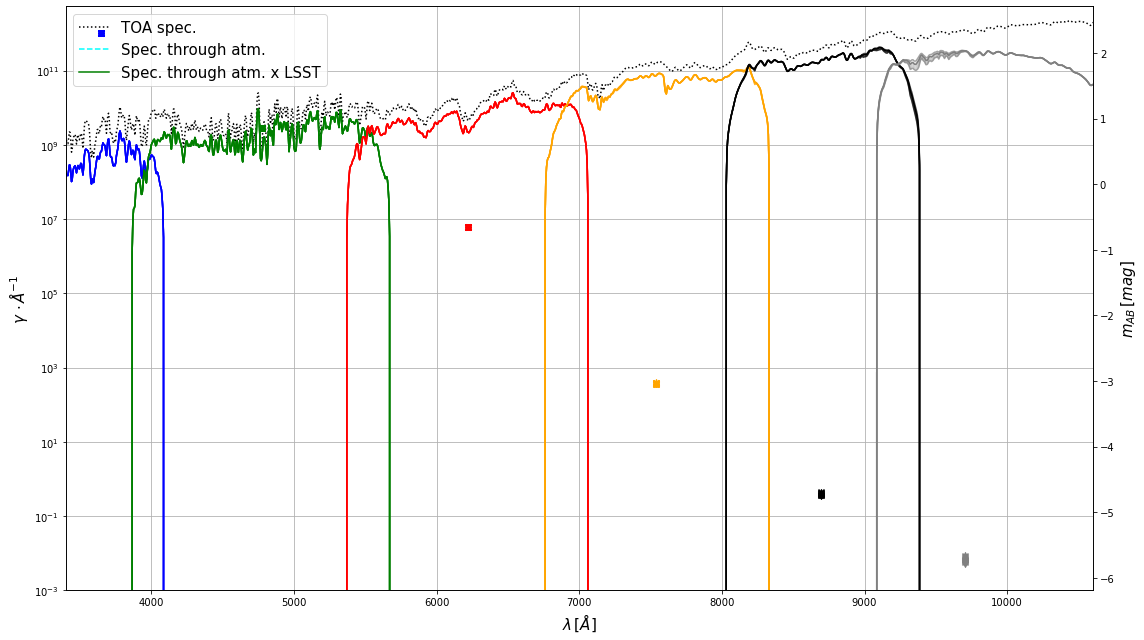

In [74]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()

for index,filter in enumerate(filters):
    print(filter)
    obs = obs_flux_std_dict[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    for i in range(n_sim):
        obs = obs_flux_t_dict[filter][i]
        if i==min_ind_ or i==max_ind_:
            alpha = 0.7
        else:
            alpha = 0.2
        ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=alpha)
        

ax1.set_xlim(WLMIN,WLMAX)
ax1.set_ylim(0.001,)
ax1.set_yscale("log")
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],mag_std_dict[filter],marker='o',color=filter_colors[index])
    for i in range(n_sim):
        if i==min_ind_:
            marker = 'v'
        elif i==max_ind_:
            marker = '^'
        else:
            marker = 'x'
        ax2.scatter(eff_lambda[filter],mag_t_dict[filter][i],marker=marker,color=filter_colors[index])

ax2.set_ylabel(r'$m_{AB} \, [mag]$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


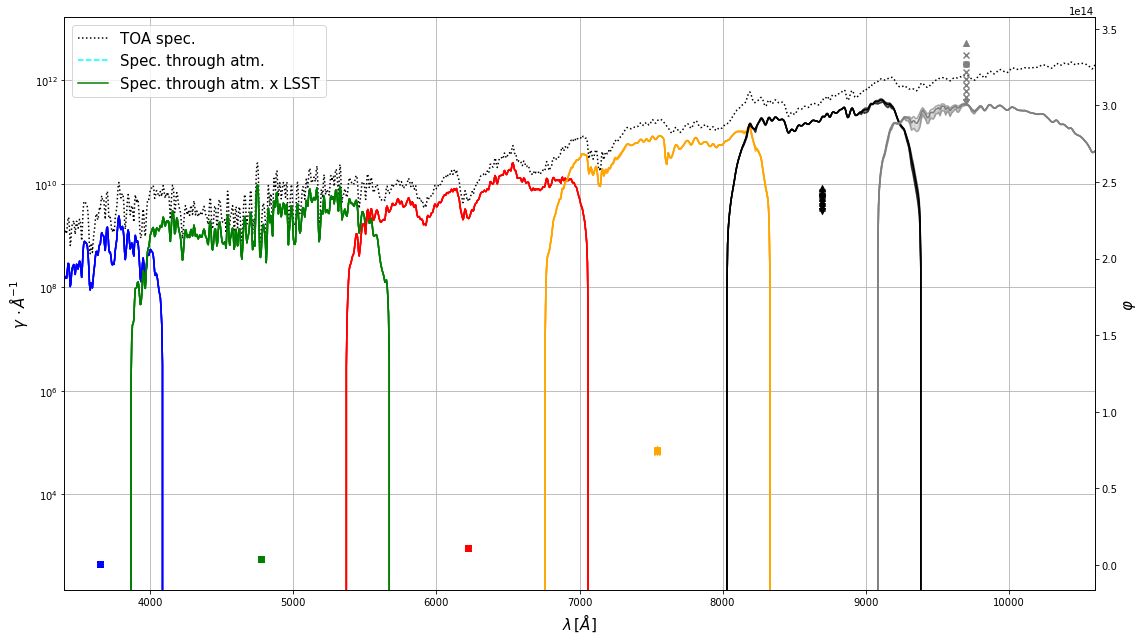

In [76]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()

for index,filter in enumerate(filters):
    print(filter)
    obs = obs_flux_std_dict[filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    for i in range(n_sim):
        obs = obs_flux_t_dict[filter][i]
        if i==min_ind_ or i==max_ind_:
            alpha = 0.7
        else:
            alpha = 0.2
        ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=alpha)
        
ax1.set_yscale("log")
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[filter],marker='o',color=filter_colors[index])
    for i in range(n_sim):
        if i==min_ind_:
            marker = '^'
        elif i==max_ind_:
            marker = 'v'
        else:
            marker = 'x'
        ax2.scatter(eff_lambda[filter],phi_t_dict[filter][i],marker=marker,color=filter_colors[index])

ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(loc="upper left",fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

# Polynomial fit of the integrated fluxes 

We have 6 bands, *ugrizY*, so we have 6 integrated fluxes, $\varphi_b$. Then, we consider the observed vector $\vec{\varphi}$. We can think of these integrated fluxes as the signal of very low resolution spectra, i.e. with very wide wavelength bins. Considering this, we associate each $\varphi_b$ with the effective wavelength, $\lambda_b^{eff}$, defined as before. 

Now, let us suppose that for a given source at a given moment we have integrated flux measurements in $N_{obs}$ bands, with $N_{obs} \leq 6$. Then, let us consider that TOA SED of the source can be described by a polynomial, $\hat{F}_{poly}(\lambda)$, of order $n = N_{obs}-1$, i.e., 

$$\hat{F}_{poly}(\lambda) = \sum_{i=0}^n a_i \lambda^i \, . $$ 

For a given band, $b$, the function $\hat{F}_{poly}(\lambda)$ should meet 

$$\int \hat{F}_{poly}(\lambda) \cdot T_b(\lambda) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h \lambda} = \varphi_b \, , $$ 

where $\hat{F}_{poly}(\lambda)$ is *fnu* units, i.e., $erg \, s^{-1} cm^{-2} Hz^{-1}$ (note the counter-intuitive notation). If we expand $\hat{F}_{poly}(\lambda)$ in its polynomial form, we can rewrite this expression as 

$$ \sum_{i=0}^n a_i \phi_b^i = \varphi_b \, , $$ 

where 

$$ \phi_b^i(t) = \int \lambda^{i-1} \cdot T_b(\lambda,t) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h} \, . $$ 

For $N \geq 2$ we will have a system of linear equations on the coefficients $a_i$: 

$$\begin{cases} 
\sum_{i=0}^n a_i \phi_{b_1}^i = \varphi_{b_1} \, \\ \qquad \vdots \\ \sum_{i=0}^n a_i \phi_{b_N}^i = \varphi_{b_N} \, . 
\end{cases}$$ 

If we express this in matrix notation, we have 

$$\begin{bmatrix} \phi_{b_1}^0 & \cdots & \phi_{b_1}^n \\ \vdots & \ddots & \vdots \\ \phi_{b_N}^0 & \cdots & \phi_{b_N}^n \end{bmatrix} \, \begin{bmatrix} a_0 \\ \vdots \\ a_n \end{bmatrix} = \begin{bmatrix} \varphi_{b_1} \\ \vdots \\ \varphi_{b_N} \end{bmatrix} \, , $$ 

or in vector notation, 

$$ M_{\phi} \vec{a} = \vec{\varphi} \, , $$ 

We note that for this matrix product $N \times (n+1) \cdot (n+1) = N $, where $N = N_{obs}$. Then, we can find the coefficients by solving 

$$ \vec{a} = M_{\phi}^{-1} \vec{\varphi} \, . $$ 

Note that the matrix $M_{\phi}$ depends only on the atmospheric conditions, so it only needs to be calculated for a given set of conditions, not for each source. 

### We compute $M_{\phi}$ by calculating the matrix elements, $\phi^i_b$ 

In [77]:
len(total_passband_ref['u'].throughput)

8501

In [78]:
len(wl_lsst)

8501

In [79]:
def phi_ij(wavelength,passband,i):
    
    T_b = passband.throughput
    assert len(wavelength)==len(T_b)
    
    phi_ij = np.trapz(wavelength**(i-1)*T_b,x=wavelength)*Seff*exptime/h_planck
    
    return phi_ij

In [80]:
phi_ij(wl_lsst,total_passband_ref['u'],1)

1.8067928067099206e+35

In [81]:
M_phi_std = np.zeros((len(filters),len(filters)))

for i in range(len(filters)):
    for j in range(len(filters)):
        #b = filters[i-int(len(extra_lambdas)/2)]
        b = filters[i]
        phi_ij_ = phi_ij(wl_lsst,total_passband_ref[b],j)
        M_phi_std[i,j] = phi_ij_

M_phi_t_dict = {}

for isim in range(n_sim):
    M_phi_t_ = np.zeros((len(filters),len(filters)))
    
    for i in range(len(filters)):
        for j in range(len(filters)):
            #b = filters[i-int(len(extra_lambdas)/2)]
            b = filters[i]
            phi_ij_ = phi_ij(wl_lsst,total_passband[b][isim],j)
            M_phi_t_[i,j] = phi_ij_
        
    M_phi_t_dict[isim] = M_phi_t_
    

In [82]:
M_phi_std.shape

(6, 6)

In [83]:
M_phi_t_dict[0].shape

(6, 6)

In [84]:
M_phi_inv_std = np.linalg.inv(M_phi_std)

M_phi_inv_t_dict = {}
for isim in range(n_sim):
    M_phi_inv_t_dict[isim] = np.linalg.inv(M_phi_t_dict[isim])



In [85]:
M_phi_inv_std

array([[ 1.37235541e-30, -1.08940384e-30,  1.95336215e-30,
        -2.36529792e-30,  1.71861926e-30, -7.12079605e-31],
       [-1.00932795e-33,  8.61204851e-34, -1.63398409e-33,
         2.04620317e-33, -1.51876142e-33,  6.39125484e-34],
       [ 2.90473756e-37, -2.61524548e-37,  5.25049066e-37,
        -6.82925590e-37,  5.19991743e-37, -2.23075672e-37],
       [-4.09612384e-41,  3.84275393e-41, -8.11952151e-41,
         1.09966875e-40, -8.62644099e-41,  3.78940300e-41],
       [ 2.83469627e-45, -2.74639320e-45,  6.06727200e-45,
        -8.55353434e-45,  6.93901629e-45, -3.13767061e-45],
       [-7.71240148e-50,  7.66649605e-50, -1.75970638e-49,
         2.57677459e-49, -2.16650243e-49,  1.01476241e-49]])

In [86]:
a_vec_std_dict = {}
a_vec_t_dict = {}


phi_std_ = []
for filter in filters:
    phi_std_.append(phi_std_dict[filter])
phi_std_ = np.array(phi_std_)

a_vec_std_dict[example_id] = np.matmul(M_phi_inv_std,phi_std_)

a_vec_t_dict[example_id] = []
for isim in range(n_sim):
    phi_t_ = []
    for filter in filters:
        phi_t_.append(phi_t_dict[filter][isim])
    phi_t_ = np.array(phi_t_)

    a_vec_t_dict[example_id].append(np.matmul(M_phi_inv_t_dict[isim],phi_t_))

#print(a_vec_std_dict)

In [87]:
len(a_vec_t_dict[example_id][0])

6

In [88]:
def poly_f(l,a,fluxunits='photlam'):
    val_ = 0.
    for i in range(len(a)):
        val_ = val_+a[i]*l**i
    
    if fluxunits=='fnu':
        A = 1.
    elif fluxunits=='flam':
        A = c_light/l**2.
    elif fluxunits=='photlam':
        A = 1./(h_planck*l)
    else:
        A = 1.
    val_ = A*val_
    
    return val_

In [89]:
poly_spec_std_dict = {}
poly_spec_t_dict = {}


wl_ = example_spec.wave
poly_spec_std_dict[example_id] = poly_f(wl_,a_vec_std_dict[example_id])

poly_spec_t_dict[example_id] = []
for isim in range(n_sim):
    poly_spec_t_dict[example_id].append(poly_f(wl_,a_vec_t_dict[example_id][isim]))

In [90]:
example_spec.fluxunits

(0.0, 0.5076220175586099)

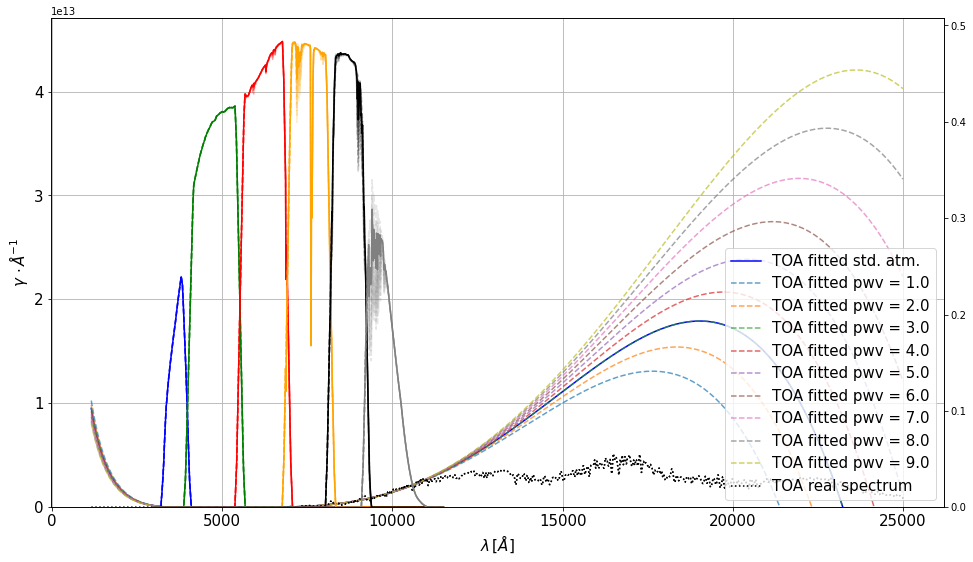

In [91]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA fitted std. atm.')
for isim in range(n_sim):
    ax.plot(example_wl,poly_spec_t_dict[example_id][isim]*Seff*exptime,ls='--',alpha=0.7,label='TOA fitted {0} = {1}'.format(variable_param,atm_vals[isim]))

ax.plot(example_wl,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
#ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11500)
#ax.set_ylim(0.,1.75e10)
ax.set_ylim(0.,)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc="lower right",fontsize=15)

ax2 = ax.twinx()
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',label=example_id)
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    for isim in range(n_sim):
        ax2.plot(total_passband[filter][isim].wave,total_passband[filter][isim].throughput,ls='--',color=filter_colors[i],alpha=0.2)
ax2.set_ylim(0.,) 


(0.0, 0.5076220175586099)

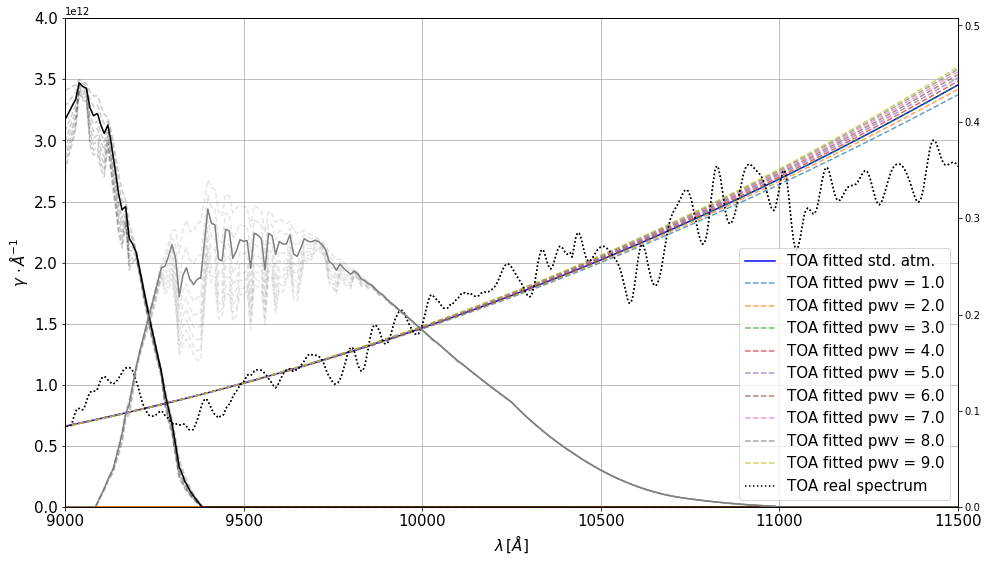

In [92]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA fitted std. atm.')
for isim in range(n_sim):
    ax.plot(example_wl,poly_spec_t_dict[example_id][isim]*Seff*exptime,ls='--',alpha=0.7,label='TOA fitted {0} = {1}'.format(variable_param,atm_vals[isim]))

ax.plot(example_wl,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
#ax.set_xlim(WLMIN,WLMAX)
ax.set_xlim(9000,11500)
#ax.set_ylim(0.,1.75e10)
ax.set_ylim(0.,0.4e13)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc="lower right",fontsize=15)

ax2 = ax.twinx()
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',label=example_id)
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    for isim in range(n_sim):
        ax2.plot(total_passband[filter][isim].wave,total_passband[filter][isim].throughput,ls='--',color=filter_colors[i],alpha=0.2)
ax2.set_ylim(0.,) 


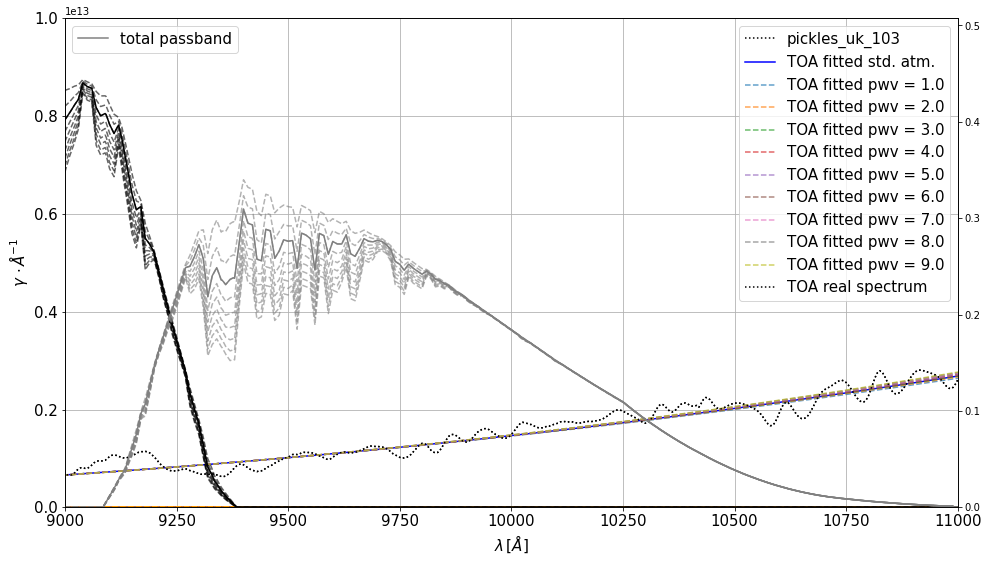

In [93]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',label=example_id)

ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA fitted std. atm.')
for isim in range(n_sim):
    ax.plot(example_wl,poly_spec_t_dict[example_id][isim]*Seff*exptime,ls='--',alpha=0.7,label='TOA fitted {0} = {1}'.format(variable_param,atm_vals[isim]))

ax.plot(example_wl,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
ax.set_xlim(9000.,11000.)
ax.set_ylim(0.,1e13)
#ax.set_ylim(0,0.4e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc="upper right",fontsize=15)

ax2 = ax.twinx()
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    for isim in range(n_sim):
        ax2.plot(total_passband[filter][isim].wave,total_passband[filter][isim].throughput,ls='--',color=filter_colors[i],alpha=0.6)
ax2.set_ylim(0.,)
ax2.plot([],[],ls='-',color='grey',label='total passband')
ax2.legend(loc="upper left",fontsize=15)


In [94]:
poly_spec_std_dict

{'pickles_uk_103': array([  980878.06,   971121.7 ,   961472.25, ..., -2464133.2 ,
        -2473142.5 , -2482189.2 ], dtype=float32)}

### Poner en formato pysynphot 

In [95]:
poly_dict = {}

poly_dict[example_id] = {}
wl_ = example_spec.wave
poly0_ = S.ArraySpectrum(wl_,poly_spec_std_dict[example_id])
poly_dict[example_id]['std'] = poly0_

for isim in range(n_sim):
    poly0_ = S.ArraySpectrum(wl_,poly_spec_t_dict[example_id][isim])
    poly_dict[example_id][isim] = poly0_
        
    

Warning, 523 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 896 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 707 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 523 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 338 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 168 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 167 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 165 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 164 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 163 of 4771 bins contained negative fluxes; they have been set to zero.


In [96]:
poly_dict

{'pickles_uk_103': {'std': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb080cab50>,
  0: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ae5b430>,
  1: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb085974f0>,
  2: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad33700>,
  3: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad33a60>,
  4: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad33d90>,
  5: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad33e20>,
  6: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad33c10>,
  7: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad338b0>,
  8: <pysynphot.spectrum.ArraySourceSpectrum at 0x7fdb0ad33880>}}

### Compute the $\hat{F}_{poly}(\lambda;t)$ through the corresponding **current atmosphere** 

**Note:** we store separately the $\hat{F}(\lambda;std)$ spectra through the standard atmosphere just for checking purposes 

In [97]:

obs_poly_std_dict = {}
obs_poly_t_dict = {}

obs_poly_std_dict[example_id] = {}
obs_poly_t_dict[example_id] = {}
for filter in filters:
    poly_total_ = S.Observation(poly_dict[example_id]['std'],total_passband_ref[filter],force='taper')
    obs_poly_std_dict[example_id][filter] = poly_total_

    obs_poly_t_dict[example_id][filter] = []
    for isim in range(n_sim):
        poly_total_ = S.Observation(poly_dict[example_id][isim],total_passband[filter][isim],force='taper')
        obs_poly_t_dict[example_id][filter].append(poly_total_)
            
    

### Compute the $\hat{F}_{poly}(\lambda;t)$ through the **standard atmosphere** 

In [98]:
std_poly_t_dict = {}

std_poly_t_dict[example_id] = {}

for filter in filters:
    std_poly_t_dict[example_id][filter] = []
    for isim in range(n_sim):
        poly_cross_ = S.Observation(poly_dict[example_id][isim],total_passband_ref[filter],force='taper')
        std_poly_t_dict[example_id][filter].append(poly_cross_)
        
    

u
g
r
i
z
Y
photlam


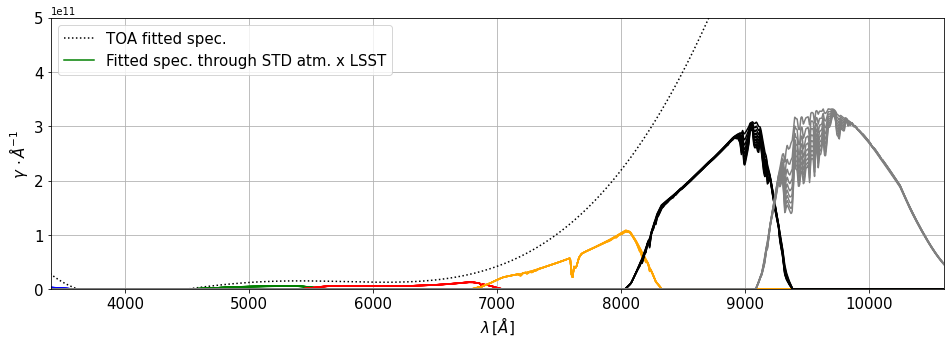

In [99]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(poly_dict[example_id]['std'].wave,poly_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    for isim in range(n_sim):
        obs = obs_poly_t_dict[example_id][filter][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
ax.set_ylim(0.,0.5e12)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


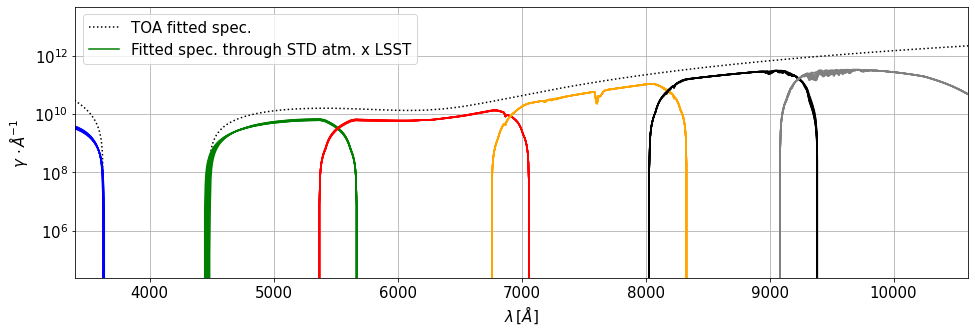

In [100]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(poly_dict[example_id]['std'].wave,poly_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    for isim in range(n_sim):
        obs = obs_poly_t_dict[example_id][filter][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
#ax.set_ylim(0.001,0.7e12)
ax.set_yscale("log")
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


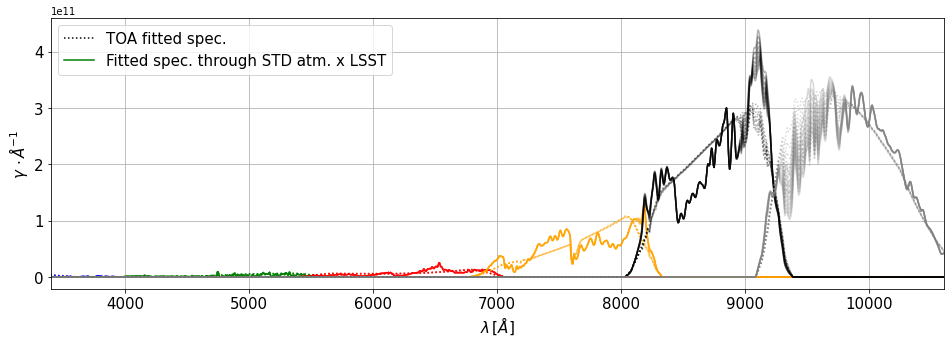

In [101]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter in enumerate(filters):
    print(filter)
    for isim in range(n_sim):
        obs = obs_flux_t_dict[filter][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.3)
        obs = obs_poly_t_dict[example_id][filter][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls=':',color=filter_colors[index],alpha=0.3)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
#ax.set_ylim(0.,0.5e12)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

Magnitudes through corresponding current atmosphere 

In [102]:
for isim in range(n_sim):
    print(isim,atm_vals[isim])
    poly_ = poly_dict[example_id][isim]
    poly_phi_,poly_mag_ = int_flux(poly_,total_passband['Y'][isim],filter=lsst_bp[-1],return_mag=True,PhiAB=Phi_AB[-1])
    spec_phi_,spec_mag_ = int_flux(example_spec,total_passband['Y'][isim],filter=lsst_bp[-1],return_mag=True,PhiAB=Phi_AB[-1])
    
    print(poly_mag_,spec_mag_,(poly_mag_-spec_mag_)*1000.)
    print('-----------')
        

0 1.0
-5.787628367824941 -5.7876315120667865 0.0031442418455540633
-----------
1 2.0
-5.763444454747945 -5.763437712352748 -0.006742395196823736
-----------
2 3.0
-5.743584521751868 -5.743585369153768 0.0008474019006499134
-----------
3 4.0
-5.726375438679483 -5.726373469197734 -0.0019694817492421635
-----------
4 5.0
-5.711026326998616 -5.711028682243143 0.0023552445265195843
-----------
5 6.0
-5.696949286377277 -5.696951245179175 0.0019588018984606492
-----------
6 7.0
-5.683689004271484 -5.683689975322894 0.0009710514099481315
-----------
7 8.0
-5.6703203152324555 -5.670319076046598 -0.0012391858579263726
-----------
8 9.0
-5.659234693901029 -5.659236863987629 0.0021700866001950203
-----------


### Convergence problem with polynomials 

The polynomial will diverge when $\lambda \to \infty$ and may also have an undesired behaviour when $\lambda \to 0$, as we can see 


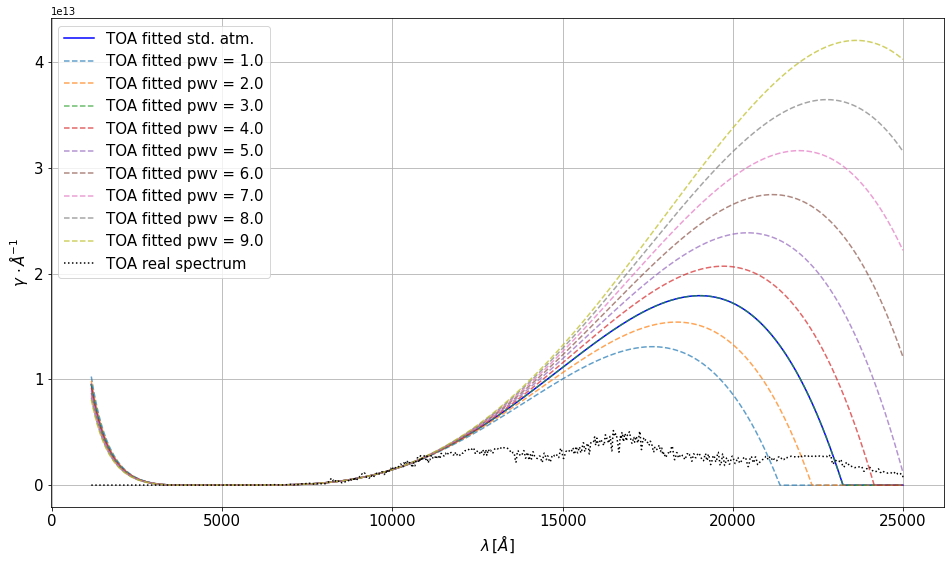

In [102]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA fitted std. atm.')
for isim in range(n_sim):
    ax.plot(example_wl,poly_spec_t_dict[example_id][isim]*Seff*exptime,ls='--',alpha=0.7,label='TOA fitted {0} = {1}'.format(variable_param,atm_vals[isim]))

ax.plot(example_wl,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
#ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,10500)
#ax.set_ylim(0.,1.75e10)
#ax.set_ylim(0,0.4e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)



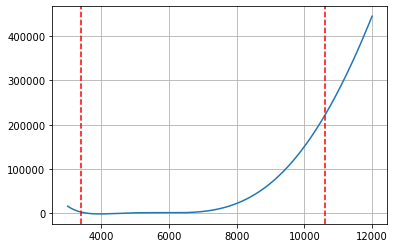

In [103]:
plt.plot(np.arange(wl_lsst[0],12000.),poly_f(np.arange(wl_lsst[0],12000.),a_vec_std_dict[example_id]))
plt.axvline(x=WLMIN,ls='--',color='r')
plt.axvline(x=WLMAX,ls='--',color='r')
plt.grid()

### Impose that $\lim_{\lambda \to \infty} \hat{F}(\lambda) \to 0$ 

We need to obtain a $\hat{F}(\lambda)$ from $\hat{F}_{poly}(\lambda)$ that meets these conditions. To impose them and obtain $\hat{F}(\lambda)$, we do the following: 

- Evaluate $\hat{F}_{poly}(\lambda)$ at the effective wavelength, $\lambda_{eff}$, of each passband, so we get $\hat{F}_{poly}(\lambda_{eff})$; 
- Add to contour conditions for $\hat{F}(\lambda)$: 
    - $\hat{F}(0) = 0$; 
    - $\hat{F}(\lambda_{\infty}) = 0$, where $\lambda_{\infty}$ is a sufficiently high wavelength, well beyond the limit of our reddest passband. 


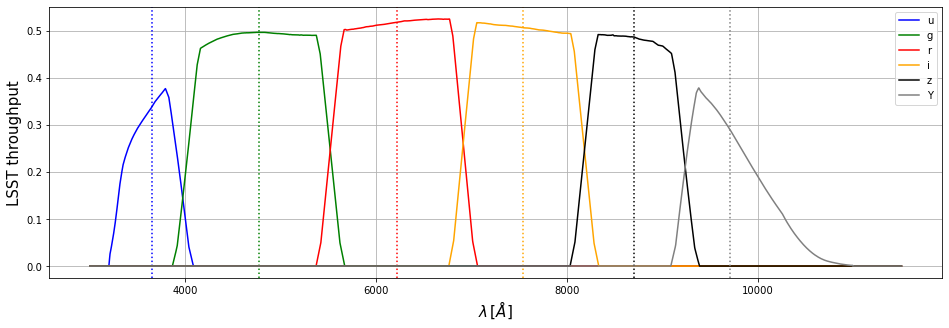

In [104]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('LSST throughput',fontsize=15)
ax.legend()

In [150]:
np.trapz(lsst_bp[1].throughput,x=lsst_bp[1].wave)

730.9453489852557

In [105]:
WLMIN,WLMAX

(3400.0, 10600.0)

In [106]:
wl_b_min = np.min(lsst_bp[0].wave[lsst_bp[0].throughput!=0.])
wl_r_max = np.max(lsst_bp[-1].wave[lsst_bp[-1].throughput!=0.])
print(wl_b_min,wl_r_max)

extra_wls = 1
Delta_lambda_r = 10

extra_lambdas = [0]

for i in range(1,extra_wls+1):
    print(i)
    extra_lambdas.append(wl_r_max+i*Delta_lambda_r*(eff_lambda_vec[-1]-eff_lambda_vec[-2]))

extra_lambdas = np.sort(extra_lambdas)

print(extra_lambdas)


3200.0000000000455 10989.000000001815
1
[    0.         21061.75280731]


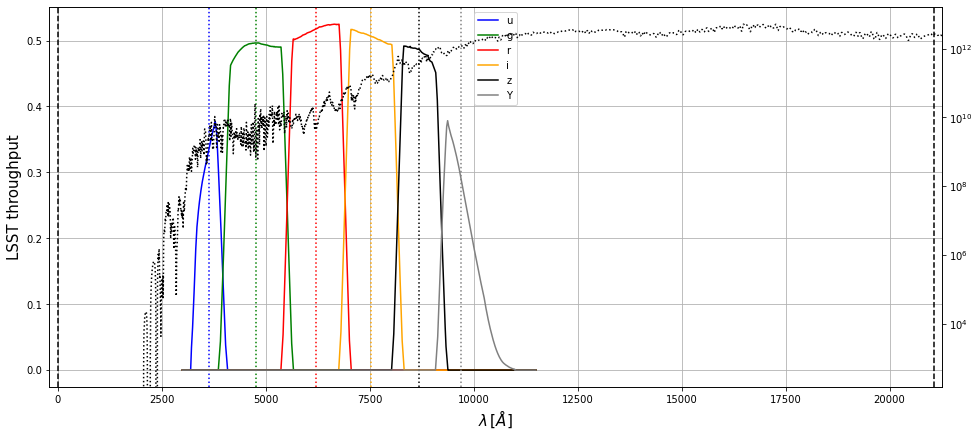

In [107]:
fig=plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
for l_ in extra_lambdas:
    ax.axvline(x=l_,ls='--',color='k')
ax2.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k')
ax2.set_yscale("log")
ax.set_xlim(extra_lambdas[0]-200.,extra_lambdas[-1]+200.)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('LSST throughput',fontsize=15)
ax.legend()

In [108]:
xpoints = [extra_lambdas[0]]
ypoints = [0.]
for leff_ in eff_lambda_vec:
    xpoints.append(leff_)
    poly_val_ = poly_f(leff_,a_vec_std_dict[example_id])
    ypoints.append(poly_val_)
xpoints.append(extra_lambdas[-1])
ypoints.append(0.)
xpoints = np.array(xpoints)
ypoints = np.array(ypoints)

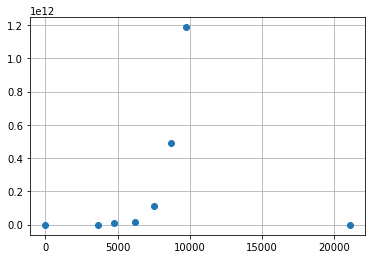

In [109]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o')
#plt.ylim(0.,1.4e10)
plt.grid()

### Splines 

We compute splines on $\hat{F}_{poly}(\Lambda)$, where $\Lambda = \{\lambda_{eff,b},0,\lambda_{\infty}\}$ 

In [110]:
from scipy.interpolate import splrep, BSpline

In [111]:
tck = splrep(xpoints, ypoints, s=0)
tck_s = splrep(xpoints, ypoints, s=len(xpoints))
tck2 = splrep(xpoints, ypoints, s=0, k=2)
tck4 = splrep(xpoints, ypoints, s=0, k=4)

In [112]:
xnew = np.linspace(extra_lambdas[0],extra_lambdas[-1],100000)

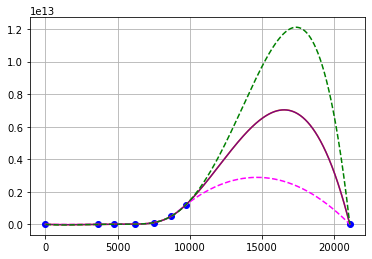

In [113]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o',color='b')
plt.plot(xnew,BSpline(*tck)(xnew)*Seff*exptime,ls='-',color='orange')
plt.plot(xnew,BSpline(*tck_s)(xnew)*Seff*exptime,ls='-',color='purple')
plt.plot(xnew,BSpline(*tck2)(xnew)*Seff*exptime,ls='--',color='magenta')
plt.plot(xnew,BSpline(*tck4)(xnew)*Seff*exptime,ls='--',color='g')
#plt.ylim(0.,1.4e10)
plt.grid()

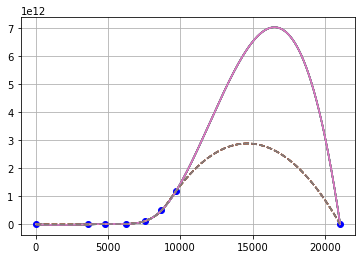

In [114]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o',color='b')
for s_ in range(0,len(xpoints)+1):
    tck_ = splrep(xpoints, ypoints, s=i,k=3)
    tck2_ = splrep(xpoints, ypoints, s=i,k=2)
    
    #print(BSpline(*tck2_)(xnew))
    plt.plot(xnew,BSpline(*tck_)(xnew)*Seff*exptime,ls='-')
    plt.plot(xnew,BSpline(*tck2_)(xnew)*Seff*exptime,ls='--')
plt.grid()

In [115]:
poly_spec_std_dict

{'pickles_uk_103': array([980878.06, 971121.7 , 961472.25, ...,      0.  ,      0.  ,
             0.  ], dtype=float32)}

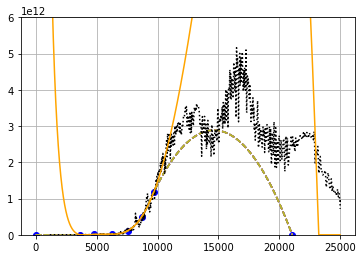

In [116]:
plt.plot(xpoints,ypoints*Seff*exptime,ls='',marker='o',color='b')
for s_ in range(0,len(xpoints)+1):
    tck2_ = splrep(xpoints, ypoints, s=i,k=2)
    
    #print(BSpline(*tck2_)(xnew))
    plt.plot(xnew,BSpline(*tck2_)(xnew)*Seff*exptime,ls='--')
    
plt.plot(example_wl,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
plt.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='orange',label='Polynomial')
plt.ylim(0.,0.6e13)
plt.grid()

To obtain a smoother $\hat{F}(\lambda)$ from the splines, we also consider some additional wavelengths around the $\lambda_{eff}$'s. Since we are evaluating $\hat{F}_{poly}(\lambda)$ on those wavelengths and in order to avoid increasing trends with $\lambda$, for the reddest $\lambda_{eff}$ we only incoporate bluer wavelengths  

In [117]:
poly_lambda = []
sp_lambda = [extra_lambdas[0]]
Delta_lambda = 0.05
lambda_steps = 3
for leff_ in eff_lambda_vec:
    #if leff_==eff_lambda_vec[0]:
    #    for dl_ in np.linspace(0,Delta_lambda,int(lambda_steps/2)+1):
    #        poly_lambda.append(leff_*(1.+dl_))
    #        sp_lambda.append(leff_*(1.+dl_))
    if leff_==eff_lambda_vec[-1]:
        for dl_ in np.linspace(0,Delta_lambda,int(lambda_steps/2)+1):
            poly_lambda.append(leff_*(1.-dl_))
            sp_lambda.append(leff_*(1.-dl_))
    else:
        for dl_ in np.linspace(-Delta_lambda,Delta_lambda,lambda_steps):
            #print(leff_*(1.+dl_))
            poly_lambda.append(leff_*(1.+dl_))
            sp_lambda.append(leff_*(1.+dl_))
            #print('-------')
sp_lambda.append(extra_lambdas[-1])
sp_lambda = np.sort(sp_lambda)
poly_lambda = np.sort(poly_lambda)
print(sp_lambda)
print(poly_lambda)
print(len(sp_lambda),len(poly_lambda))

[    0.          3464.33210392  3646.66537255  3828.99864118
  4536.90545242  4775.68994991  5014.47444741  5910.7658115
  6221.85874895  6532.9516864   7161.80510151  7538.74221212
  7915.67932273  8261.19041029  8695.98990557  9130.78940085
  9218.10192698  9703.2651863  21061.75280731]
[3464.33210392 3646.66537255 3828.99864118 4536.90545242 4775.68994991
 5014.47444741 5910.7658115  6221.85874895 6532.9516864  7161.80510151
 7538.74221212 7915.67932273 8261.19041029 8695.98990557 9130.78940085
 9218.10192698 9703.2651863 ]
19 17


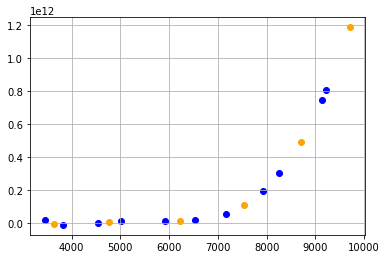

In [118]:
for l_ in poly_lambda:
    if l_ in eff_lambda_vec:
        color = 'orange'
    else:
        color = 'b'
    plt.scatter(l_,poly_f(l_,a_vec_std_dict[example_id])*Seff*exptime,marker='o',color=color)
plt.grid()

### NOTE: 

For the red tail we use an order = 2 spline, while for the blue tail we use an order = 1 spline 

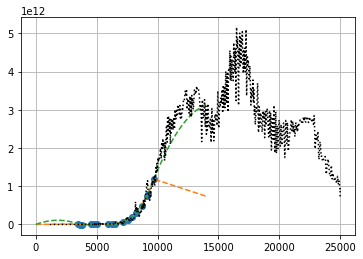

In [119]:
plt.plot(poly_lambda,poly_f(poly_lambda,a_vec_std_dict[example_id])*Seff*exptime,ls='',marker='o')

spline_vals_ = np.array([0.]+list(poly_f(poly_lambda,a_vec_std_dict[example_id]))+[0.]*extra_wls)
tck1_ = splrep(sp_lambda,spline_vals_,s=0,k=1)
tck2_ = splrep(sp_lambda,spline_vals_,s=0,k=2)

#print(BSpline(*tck2_)(xnew))
plt.plot(np.linspace(0.,14000.,1000),BSpline(*tck1_)(np.linspace(0.,14000.,1000))*Seff*exptime,ls='--')
plt.plot(np.linspace(0.,14000.,1000),BSpline(*tck2_)(np.linspace(0.,14000.,1000))*Seff*exptime,ls='--')
plt.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
plt.grid()

In [120]:
new_lambda_ = np.linspace(0.,14000.,1000)
new_spec_ = np.array(list(BSpline(*tck1_)(new_lambda_[new_lambda_<=poly_lambda[0]]))+list(BSpline(*tck2_)(new_lambda_[new_lambda_>poly_lambda[0]])))

(0.0, 0.507613905900376)

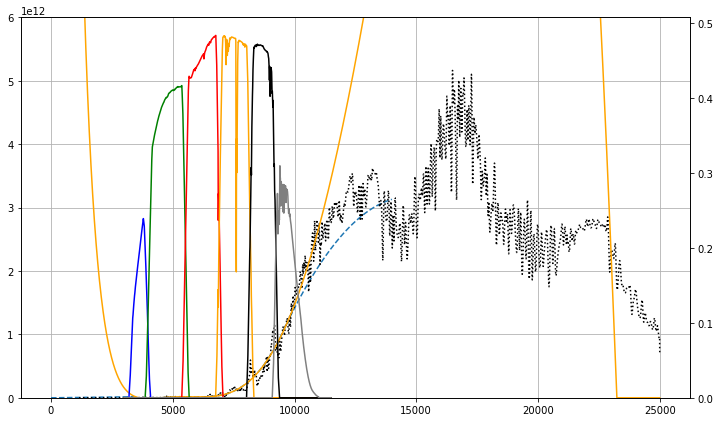

In [121]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(new_lambda_,new_spec_*Seff*exptime,ls='--')
ax.plot(example_wl,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='orange',label='Polynomial')
ax.set_ylim(0.,0.6e13)
ax.grid()

ax2 = ax.twinx()
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
ax2.set_ylim(0.,)


(0.0, 0.507613905900376)

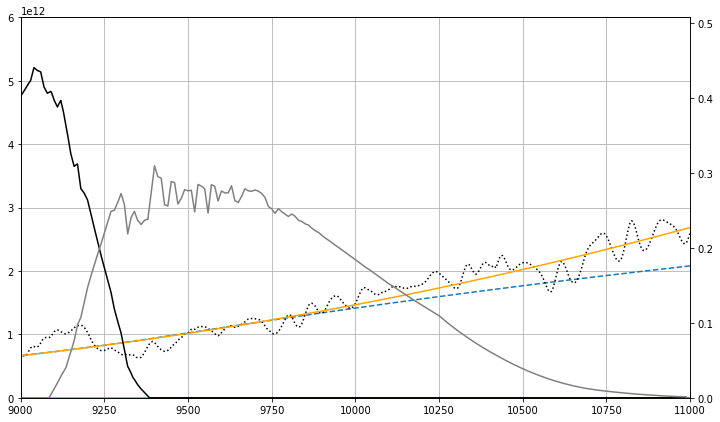

In [122]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(new_lambda_,new_spec_*Seff*exptime,ls='--')
ax.plot(example_wl,example_spec.flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls='-',color='orange',label='Polynomial')
ax.set_xlim(9000.,11000.)
ax.set_ylim(0.,0.6e13)
ax.grid()

ax2 = ax.twinx()
for i,filter in enumerate(filters):
    ax2.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
ax2.set_ylim(0.,)


### We make the spline spectrum pass through the different total passbands 

**NOTE:** for each object $\mu$ and for each atmospheric condition (standard and non-standard) we compute a $\hat{F}_i(\lambda)$, because this is what we will actually have at each moment. That is, $\hat{F}_i(\lambda) = \hat{F}_i(\lambda ; std)$ or $ \hat{F}_i(\lambda ; t)$. 

We pass the **estimated spectra** through the **standard atmosphere**, so we obtain what we call $\vec{\Phi}^{std}_i$. **Note that we will have one $\vec{\Phi}^{std}_i$ from each estimated $\hat{F}_i(\lambda)$, that is, for each $\vec{\varphi}_i(t)$.** 

For the two extreme cases (minimum and maximum total passbands), we pass the corresponding estimated spectra through the corresponding atmosphere, obtaining what we refer to as $\vec{\Phi}_i(t)$, that is, the **estimated spectrum** passing through the **current atmosphere**. It could also happen that the current atmosphere is equal to the standard one. In that case, $\vec{\Phi}_i(t)$ will be equal to $\vec{\Phi}^{std}_i$ and therefore the corrected flux, $\vec{\varphi}^{\, corr}_i$, will be equal to the observed one $\vec{\varphi}_i(t)$. 


In [123]:
s_spline = 0
k_spline_b = 1
k_spline_r = 2

In [124]:
spline_spec_std_dict = {}
spline_spec_t_dict = {}

sp_vals_ = [0.]+list(poly_f(poly_lambda,a_vec_std_dict[example_id]))+[0.]*extra_wls
sp_vals_ = np.array(sp_vals_)
assert len(sp_vals_)==len(sp_lambda)

spline_b_ = splrep(sp_lambda,sp_vals_,s=s_spline,k=k_spline_b)
spline_r_ = splrep(sp_lambda,sp_vals_,s=s_spline,k=k_spline_r)
wl_ = example_spec.wave
spline_spec_ = np.array(list(BSpline(*spline_b_)(wl_[wl_<=poly_lambda[0]]))+list(BSpline(*spline_r_)(wl_[wl_>poly_lambda[0]])))
spline_spec_std_dict[example_id] = spline_spec_

spline_spec_t_dict[example_id] = []
for isim in range(n_sim):
    sp_vals_ = [0.]+list(poly_f(poly_lambda,a_vec_t_dict[example_id][isim]))+[0.]*extra_wls
    sp_vals_ = np.array(sp_vals_)

    spline_b_ = splrep(sp_lambda,sp_vals_,s=s_spline,k=k_spline_b)
    spline_r_ = splrep(sp_lambda,sp_vals_,s=s_spline,k=k_spline_r)
    spline_spec_ = np.array(list(BSpline(*spline_b_)(wl_[wl_<=poly_lambda[0]]))+list(BSpline(*spline_r_)(wl_[wl_>poly_lambda[0]])))
    spline_spec_t_dict[example_id].append(spline_spec_)


(0.0, 1.0)

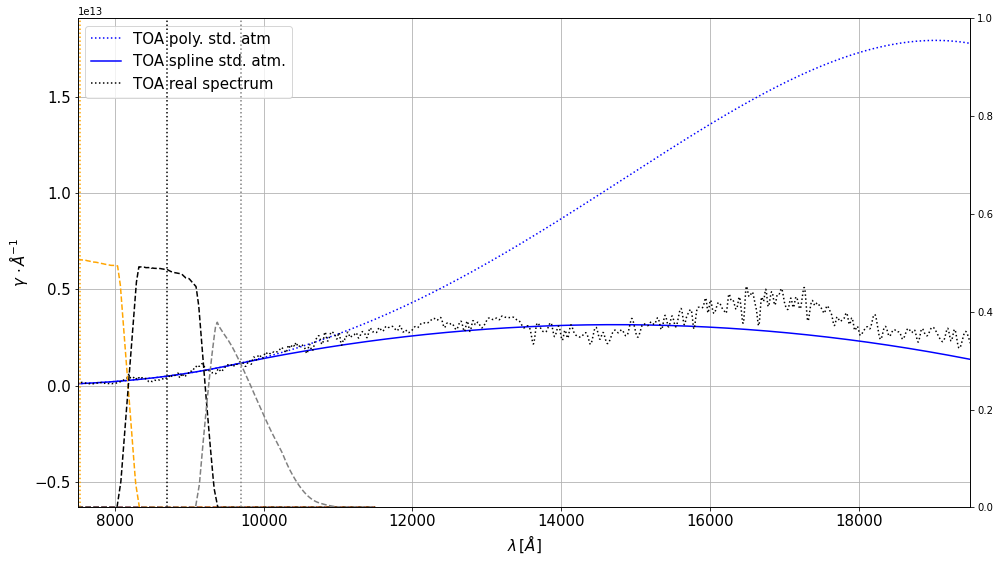

In [125]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,ls=':',color='b',label='TOA poly. std. atm')
ax.plot(example_wl,spline_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA spline std. atm.')

ax.plot(example_wl,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
#ax.set_xlim(WLMIN,WLMAX)
ax.set_xlim(7500,19500)
#ax.set_ylim(0.,0.25e13)
#ax.set_ylim(0,0.4e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)

ax2 = ax.twinx()

for i,filter in enumerate(filters):
    ax2.plot(lsst_bp[i].wave,lsst_bp[i].throughput,ls='--',color=filter_colors[i],label=filter_names[i])
    ax2.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
for l_ in extra_lambdas:
    ax2.axvline(x=l_,ls='--',color='k')
ax2.set_ylim(0.,1.)


### Set up the spline spectra in pysynphot format 

In [126]:
spline_dict = {}

spline_dict[example_id] = {}
wl_ = sed_dict[example_id].wave
spline0_ = S.ArraySpectrum(wl_,spline_spec_std_dict[example_id])
spline_dict[example_id]['std'] = spline0_

for isim in range(n_sim):
    spline0_ = S.ArraySpectrum(wl_,spline_spec_t_dict[example_id][isim])
    spline_dict[example_id][isim] = spline0_
        
    

Warning, 957 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 960 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 959 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 957 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 956 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 955 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 953 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 952 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 951 of 4771 bins contained negative fluxes; they have been set to zero.
Warning, 950 of 4771 bins contained negative fluxes; they have been set to zero.


### Compute the $\hat{F}(\lambda;t)$ through the corresponding **current atmosphere** 

**Note:** we store separately the $\hat{F}(\lambda;std)$ spectra through the standard atmosphere just for checking purposes 

In [127]:

obs_spline_std_dict = {}
obs_spline_t_dict = {}

obs_spline_std_dict[example_id] = {}
obs_spline_t_dict[example_id] = {}
for filter in filters:
    spline_total_ = S.Observation(spline_dict[example_id]['std'],total_passband_ref[filter],force='taper')
    obs_spline_std_dict[example_id][filter] = spline_total_

    obs_spline_t_dict[example_id][filter] = []
    for isim in range(n_sim):
        spline_total_ = S.Observation(spline_dict[example_id][isim],total_passband[filter][isim],force='taper')
        obs_spline_t_dict[example_id][filter].append(spline_total_)
            
    

### Compute the $\hat{F}(\lambda;t)$ through the **standard atmosphere** 

In [128]:
std_spline_t_dict = {}

std_spline_t_dict[example_id] = {}

for filter in filters:
    std_spline_t_dict[example_id][filter] = []
    for isim in range(n_sim):
        spline_cross_ = S.Observation(spline_dict[example_id][isim],total_passband_ref[filter],force='taper')
        std_spline_t_dict[example_id][filter].append(spline_cross_)
        
    

In [129]:
std_spline_t_dict[example_id][filter]

u
g
r
i
z
Y
photlam


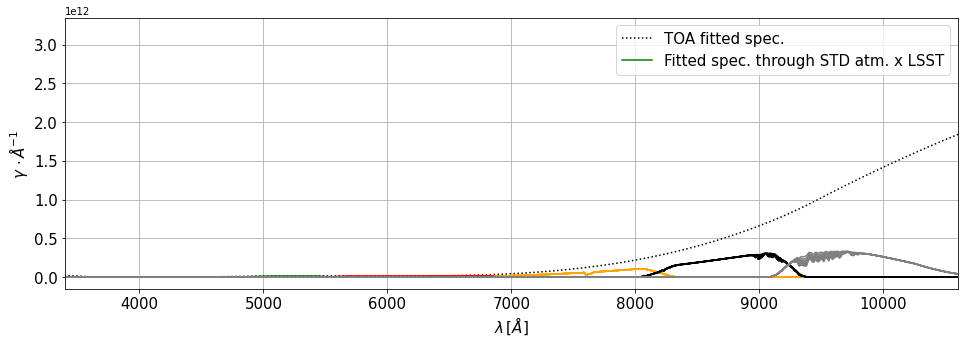

In [130]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(spline_dict[example_id][4].wave,spline_dict[example_id][4].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax.plot(poly_atm_std.binwave,poly_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter in enumerate(filters):
    print(filter)
    for isim in range(n_sim):
        obs = obs_spline_t_dict[example_id][filter][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
#ax.set_ylim(0.,0.2e10)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

## IMPORTANT NOTE: 

All the following integrated spectra correspond to $\vec{\Phi}_i(t)$, that is, to each estimated $\hat{F}_i(\lambda;t)$ passing through the atmosphere they were inferred from, i.e. the current atmosphere. **This includes the standard atmosphere case.** This is so because, as we mentioned before, one possible situation is that the current atmosphere corresponds to the standard one. WE MUST NOT interpret the following integrated fluxes as the different $\vec{\Phi}_i^{std}$ vectors, which will correspond to the different $\hat{F}_i(\lambda;t)$ passing through the standard atmosphere. 


Compute the $\vec{\Phi}_i(t)$ values. We also compute the magnitudes obtained from $\vec{\Phi}_i(t)$ as 

$$\vec{\mathbb{m}}_i(t) = -2.5 \log_{10} \frac{\vec{\Phi}_i(t)}{\Phi_{AB}} \, . $$ 

In [131]:
Phi_t_dict = {}
Mag_t_dict = {}

poly_Phi_t_dict = {}
poly_Mag_t_dict = {}

Phi_t_dict[example_id] = {}
Mag_t_dict[example_id] = {}

poly_Phi_t_dict[example_id] = {}
poly_Mag_t_dict[example_id] = {}
for index,filter in enumerate(filters):
    Phi_t_dict[example_id][filter] = []
    Mag_t_dict[example_id][filter] = []
    
    poly_Phi_t_dict[example_id][filter] = []
    poly_Mag_t_dict[example_id][filter] = []
    for isim in range(n_sim):
        num_,mag_ = int_flux(spline_dict[example_id][isim],total_passband[filter][isim],return_mag=True,PhiAB=Phi_AB[index])
        Phi_t_dict[example_id][filter].append(num_)
        Mag_t_dict[example_id][filter].append(mag_)
        
        num_,mag_ = int_flux(poly_dict[example_id][isim],total_passband[filter][isim],return_mag=True,PhiAB=Phi_AB[index])
        poly_Phi_t_dict[example_id][filter].append(num_)
        poly_Mag_t_dict[example_id][filter].append(mag_)
        
    
    

Compute the $\vec{\Phi}_i^{std}$ values. Similarly, we also calculate the magnitudes obtained from $\vec{\Phi}_i^{std}$ as 

$$\vec{\mathbb{m}}_i^{std} = -2.5 \log_{10} \frac{\vec{\Phi}_i^{std}}{\Phi_{AB}} \, . $$ 

In [132]:
Phi_std_dict = {}
Mag_std_dict = {}

poly_Phi_std_dict = {}
poly_Mag_std_dict = {}

Phi_std_dict[example_id] = {}
Mag_std_dict[example_id] = {}

poly_Phi_std_dict[example_id] = {}
poly_Mag_std_dict[example_id] = {}
for index,filter in enumerate(filters):
    Phi_std_dict[example_id][filter] = []
    Mag_std_dict[example_id][filter] = []
    
    poly_Phi_std_dict[example_id][filter] = []
    poly_Mag_std_dict[example_id][filter] = []
    for isim in range(n_sim):
        num_,mag_ = int_flux(spline_dict[example_id][isim],total_passband_ref[filter],return_mag=True,PhiAB=Phi_AB[index])
        Phi_std_dict[example_id][filter].append(num_)
        Mag_std_dict[example_id][filter].append(mag_)
        
        num_,mag_ = int_flux(poly_dict[example_id][isim],total_passband_ref[filter],return_mag=True,PhiAB=Phi_AB[index])
        poly_Phi_std_dict[example_id][filter].append(num_)
        poly_Mag_std_dict[example_id][filter].append(mag_)
        
    

### Comparison plots with respect to **standard (reference) atmosphere** 

We compare the integrated flux obtained from the **real spectrum** and the **fitted one** 

photlam


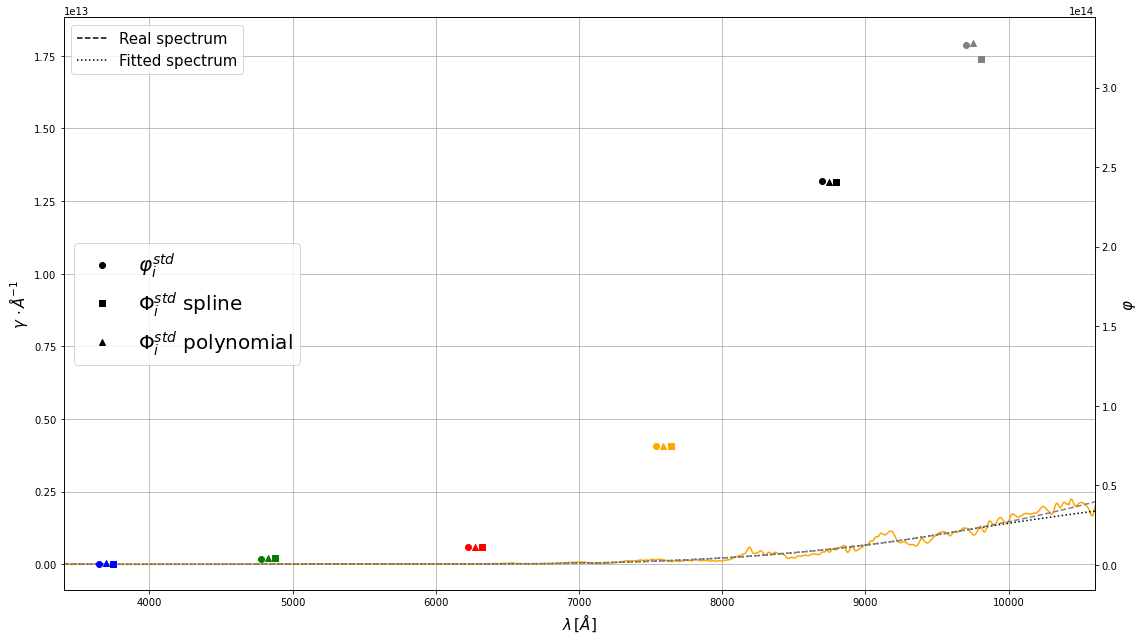

In [133]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_wl,example_spec.flux*Seff*exptime,ls='-',color='orange',alpha=1.0)
ax1.plot(example_wl,spline_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax1.plot(example_wl,poly_dict[example_id]['std'].flux*Seff*exptime,ls='--',color='grey',alpha=1.0)

ax2 = ax1.twinx()
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter]+100.,Phi_std_dict[example_id][filter][4],marker='s',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter]+50.,poly_Phi_std_dict[example_id][filter][4],marker='^',color=filter_colors[index])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$ spline')
ax2.plot([],[],ls='',marker='^',color='k',label=r'$\Phi^{std}_i$ polynomial')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15,loc="upper left")
ax2.legend(fontsize=20,loc='center left')
plt.tight_layout()
print(spec.fluxunits)

### And now we compare with the integrated fluxes from the real spectrum for each atmospheric situation 

photlam


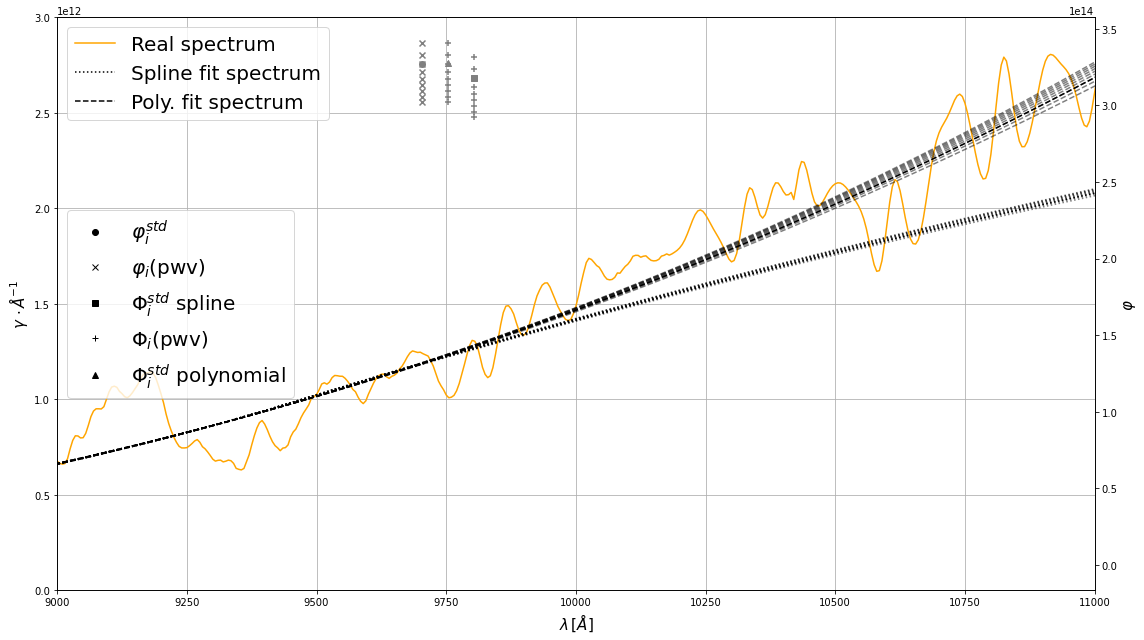

In [134]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(example_wl,example_spec.flux*Seff*exptime,ls='-',color='orange',alpha=1.0)
ax1.plot(example_wl,spline_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
ax1.plot(example_wl,poly_dict[example_id]['std'].flux*Seff*exptime,ls='--',color='k',alpha=1.0)
for isim in range(n_sim):
    ax1.plot(example_wl,spline_dict[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=0.5)
    ax1.plot(example_wl,poly_dict[example_id][isim].flux*Seff*exptime,ls='--',color='k',alpha=0.5)

ax2 = ax1.twinx()
    
#ax1.set_xlim(WLMIN,WLMAX)
ax1.set_xlim(9000.,11000.)
ax1.set_ylim(0.,0.3e13)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='-',color='orange',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Spline fit spectrum')
ax1.plot([],[],ls='--',color='k',label='Poly. fit spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[filter],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter]+100.,Phi_std_dict[example_id][filter][4],marker='s',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter]+50.,poly_Phi_std_dict[example_id][filter][4],marker='^',color=filter_colors[index])
    for isim in range(n_sim):
        ax2.scatter(eff_lambda[filter],phi_t_dict[filter][isim],marker='x',color=filter_colors[index])
        ax2.scatter(eff_lambda[filter]+100.,Phi_t_dict[example_id][filter][isim],marker='+',color=filter_colors[index])
        ax2.scatter(eff_lambda[filter]+50.,poly_Phi_t_dict[example_id][filter][isim],marker='+',color=filter_colors[index])
    
ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='x',color='k',label=r'$\varphi_i($'+'{0})'.format(variable_param))
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$ spline')
ax2.plot([],[],ls='',marker='+',color='k',label=r'$\Phi_i($'+'{0})'.format(variable_param))
ax2.plot([],[],ls='',marker='^',color='k',label=r'$\Phi^{std}_i$ polynomial')
#ax2.set_yscale("log")
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20,loc='upper left')
ax2.legend(fontsize=20,loc='center left')
plt.tight_layout()
print(spec.fluxunits)

In [135]:
Phi_std_dict[example_id]['g'][4],Phi_t_dict[example_id]['g']

(4576623488489.609,
 [4800592898570.272,
  4731213915073.94,
  4673088473973.304,
  4622061954985.355,
  4576250707483.261,
  4534642784955.763,
  4496606960671.029,
  4461744248636.93,
  4429038910991.041])

# Color compensation 

Let us introduce the notation and formalism: 

$$ m_{i,b}(t) = -2.5 \log_{10} \frac{\int F_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}}{\int F_{AB} \, T_{tel,b}(\lambda) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}} = -2.5 \log_{10} \frac{\varphi_{i,b}(t)}{\Phi_{AB,b}}$$ 

$$T_b (\lambda,t) = T_{tel,b}(\lambda) \cdot T_{atm}(\lambda,t) $$ 

$$T^{std}_b (\lambda) = T_{tel,b}(\lambda) \cdot T^{std}_{atm}(\lambda) $$ 

$$\vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$

$$\Phi^{std}_{i,b} = \int \hat{F}_i(\lambda) \, T^{std}_b(\lambda) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$

$$\Phi_{i,b}(t) = \int \hat{F}_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$ 

$$\vec{\varphi}^{\, corr}_{i,\mu+1} = \vec{\varphi}_{i,\mu}(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$ 


We compute the integrated flux correction, 

$$ \vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} \, . $$

In [136]:
phi_corr_dict = {}
poly_phi_corr_dict = {}

phi_corr_dict[example_id] = {}
poly_phi_corr_dict[example_id] = {}
for filter in filters:
    phi_corr_dict[example_id][filter] = []
    poly_phi_corr_dict[example_id][filter] = []
    for isim in range(n_sim):
        phi_corr_ = phi_t_dict[filter][isim]*Phi_std_dict[example_id][filter][isim]/Phi_t_dict[example_id][filter][isim]
        phi_corr_dict[example_id][filter].append(phi_corr_)
        
        phi_corr_ = phi_t_dict[filter][isim]*poly_Phi_std_dict[example_id][filter][isim]/poly_Phi_t_dict[example_id][filter][isim]
        poly_phi_corr_dict[example_id][filter].append(phi_corr_)
        

We compare the result of doing $ \vec{\varphi}^{\, corr}_i $ with the *real* result from the real spectrum passing through the *standard atmosphere*, that is, $\vec{\varphi}^{\, std}_i $, which we want to recover (and to which we will not have access in general)  

In [137]:
example_vec_phi_std = []
example_vec_phi_corr_dict = {}
example_vec_poly_phi_corr_dict = {}

for filter in filters:
    phi_std_ = phi_std_dict[filter]
    example_vec_phi_std.append(phi_std_)
example_vec_phi_std = np.array(example_vec_phi_std)

for isim in range(n_sim):
    example_vec_phi_corr_dict[isim] = []
    example_vec_poly_phi_corr_dict[isim] = []
    for filter in filters:
        phi_corr_ = phi_corr_dict[example_id][filter][isim]
        example_vec_phi_corr_dict[isim].append(phi_corr_)
        
        phi_corr_ = poly_phi_corr_dict[example_id][filter][isim]
        example_vec_poly_phi_corr_dict[isim].append(phi_corr_)
    example_vec_phi_corr_dict[isim] = np.array(example_vec_phi_corr_dict[isim])
    example_vec_poly_phi_corr_dict[isim] = np.array(example_vec_poly_phi_corr_dict[isim])
    

In [138]:
example_vec_phi_std

array([3.69595027e+11, 3.72109403e+12, 1.12218280e+13, 7.50576362e+13,
       2.41441314e+14, 3.26846402e+14])

In [139]:
example_vec_phi_corr_dict[n_sim-1]

array([3.69358703e+11, 3.72252471e+12, 1.12132342e+13, 7.48520836e+13,
       2.39916241e+14, 3.29937014e+14])

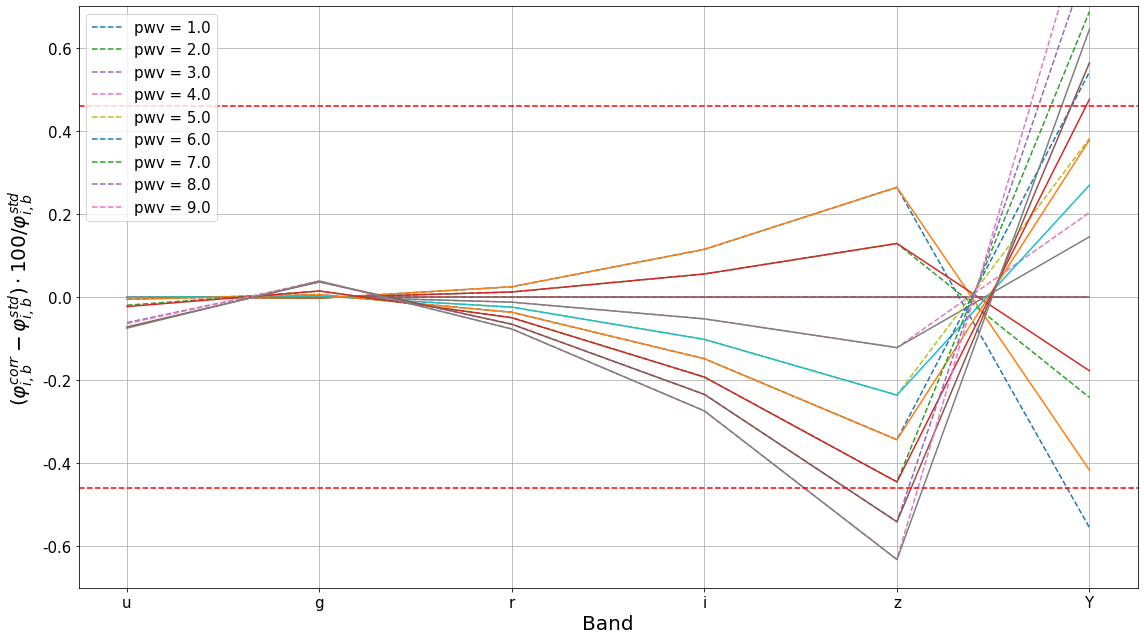

In [140]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),(example_vec_phi_corr_dict[isim]-example_vec_phi_std)*100./example_vec_phi_std,ls='--',label='{0} = {1}'.format(variable_param,atm_vals[isim]))
    ax.plot(np.arange(len(filters)),(example_vec_poly_phi_corr_dict[isim]-example_vec_phi_std)*100./example_vec_phi_std,ls='-')

phi_lim = (10.**(-0.005/2.5)-1.)*100.

ax.axhline(y=-phi_lim,ls='--',color='r')
ax.axhline(y=phi_lim,ls='--',color='r')
ax.set_ylim(-0.7,0.7)
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$(\varphi_{i,b}^{corr}-\varphi_{i,b}^{std}) \cdot 100 / \varphi_{i,b}^{std}$',fontsize=20)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

### We now work with magnitudes 

If we express the correction in magnitudes, we have 

$$\vec{m}^{\, corr}_i = \vec{m}_i(t)+\vec{\mathbb{m}}^{std}_i - \vec{\mathbb{m}}_i(t) $$

In [141]:
mag_corr_dict = {}
poly_mag_corr_dict = {}

mag_corr_dict[example_id] = {}
poly_mag_corr_dict[example_id] = {}
for filter in filters:
    mag_corr_dict[example_id][filter] = []
    poly_mag_corr_dict[example_id][filter] = []
    for isim in range(n_sim):
        mag_corr_ = mag_t_dict[filter][isim]+Mag_std_dict[example_id][filter][isim]-Mag_t_dict[example_id][filter][isim]
        mag_corr_dict[example_id][filter].append(mag_corr_)
        
        mag_corr_ = mag_t_dict[filter][isim]+poly_Mag_std_dict[example_id][filter][isim]-poly_Mag_t_dict[example_id][filter][isim]
        poly_mag_corr_dict[example_id][filter].append(mag_corr_)
        

In [142]:
example_vec_mag_std = []
example_vec_mag_corr_dict = {}
example_vec_poly_mag_corr_dict = {}

for filter in filters:
    mag_std_ = mag_std_dict[filter]
    example_vec_mag_std.append(mag_std_)
example_vec_mag_std = np.array(example_vec_mag_std)

for isim in range(n_sim):
    example_vec_mag_corr_dict[isim] = []
    example_vec_poly_mag_corr_dict[isim] = []
    for filter in filters:
        mag_corr_ = mag_corr_dict[example_id][filter][isim]
        example_vec_mag_corr_dict[isim].append(mag_corr_)
        
        mag_corr_ = poly_mag_corr_dict[example_id][filter][isim]
        example_vec_poly_mag_corr_dict[isim].append(mag_corr_)
        
    example_vec_mag_corr_dict[isim] = np.array(example_vec_mag_corr_dict[isim])
    example_vec_poly_mag_corr_dict[isim] = np.array(example_vec_poly_mag_corr_dict[isim])
    

In [143]:
example_vec_mag_std

array([ 2.305018  ,  0.86046585, -0.6510989 , -3.04284242, -4.73504749,
       -5.74358537])

In [144]:
example_vec_mag_corr_dict[n_sim-1]

array([ 2.30571246,  0.86004849, -0.65026711, -3.03986495, -4.72816765,
       -5.7538037 ])

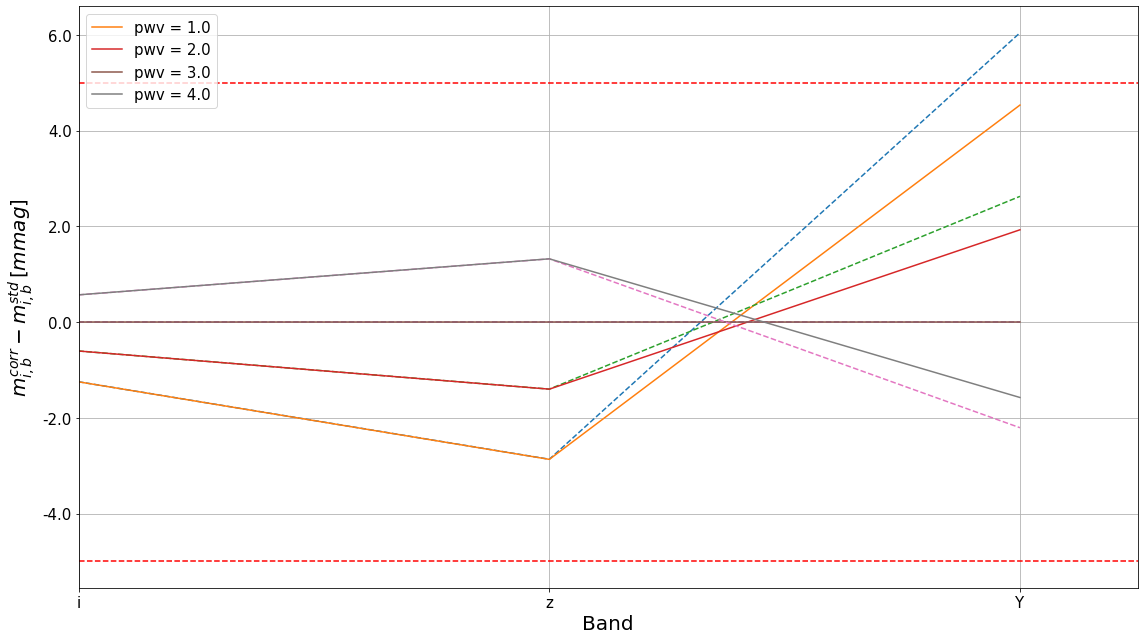

In [145]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
#for isim in range(n_sim):
for isim in range(4):
    ax.plot(np.arange(len(filters)),(example_vec_mag_corr_dict[isim]-example_vec_mag_std)*1000.,ls='--')
    ax.plot(np.arange(len(filters)),(example_vec_poly_mag_corr_dict[isim]-example_vec_mag_std)*1000.,ls='-',label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$m_{i,b}^{corr}-m_{i,b}^{std} \, [mmag]$',fontsize=20)
ax.legend(loc="best",fontsize=15)
ax.set_xlim(3,)
plt.tight_layout()

In [146]:
n_sim

9

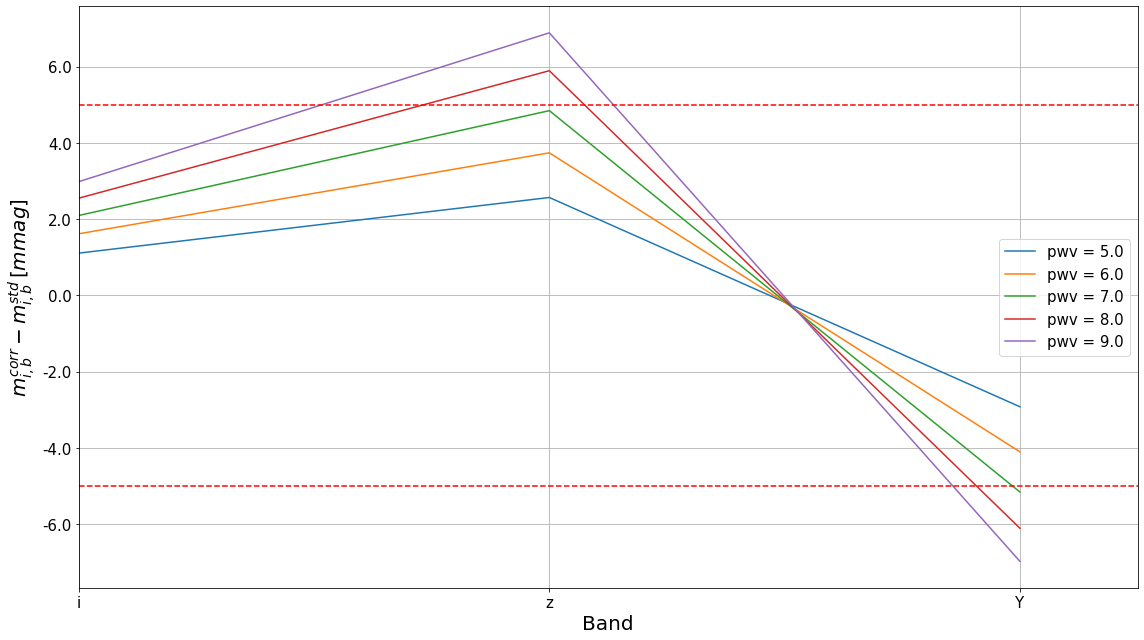

In [147]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
#for isim in range(n_sim):
for isim in range(4,9):
    #ax.plot(np.arange(len(filters)),(example_vec_mag_corr_dict[isim]-example_vec_mag_std)*1000.,ls='--')
    ax.plot(np.arange(len(filters)),(example_vec_poly_mag_corr_dict[isim]-example_vec_mag_std)*1000.,ls='-',label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$m_{i,b}^{corr}-m_{i,b}^{std} \, [mmag]$',fontsize=20)
ax.legend(loc="best",fontsize=15)
ax.set_xlim(3,)
plt.tight_layout()

In [148]:
assert False

AssertionError: 

### Impact of different atmospheres with respect to standard one 

In [ ]:
Mag_diff_dict = {}

for ised in sed_dict.keys():
    Mag_diff_dict[ised] = {}
    for filter in filters:
        Mag_diff_dict[ised][filter] = []
        for isim in range(n_sim):
            Mag_diff_ = Mag_std_dict[ised][filter][isim]-Mag_t_dict[ised][filter][isim]
            Mag_diff_dict[ised][filter].append(Mag_diff_)

In [ ]:
example_vec_Mag_diff_dict = {}

for isim in range(n_sim):
    example_vec_Mag_diff_dict[isim] = []
    for filter in filters:
        Mag_diff_ = Mag_diff_dict[example_id][filter][isim]
        example_vec_Mag_diff_dict[isim].append(Mag_diff_)
    example_vec_Mag_diff_dict[isim] = np.array(example_vec_Mag_diff_dict[isim])
    

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),example_vec_Mag_diff_dict[isim]*1000.,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$\mathbb{m}_{i,b}^{std}-\mathbb{m}_{i,b}(t) \, [mmag]$',fontsize=22)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

In [ ]:
delta_mag_dict = {}

for ised in sed_dict.keys():
    delta_mag_dict[ised] = {}
    for filter in filters:
        delta_mag_dict[ised][filter] = []
        for isim in range(n_sim):
            delta_mag_ = mag_corr_dict[ised][filter][isim]-mag_std_dict[ised][filter]
            delta_mag_dict[ised][filter].append(delta_mag_)

In [ ]:
fig = plt.figure(figsize=(12,40))

for i,filter in enumerate(filters):
    print(filter)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                delta_mag_ = delta_mag_dict[id_][filter][isim]*1000.
                
                if id_==example_id:
                    alpha = 1.0
                    marker = 'o'
                    
                    ax.scatter(atm_vals[isim],delta_mag_,marker=marker,color=type_colors[type_],alpha=alpha)
                    ax.grid()
                


In [ ]:
fig = plt.figure(figsize=(12,40))

for i,filter in enumerate(filters):
    print(filter)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                delta_mag_ = delta_mag_dict[id_][filter][isim]*1000.

                ax.scatter(atm_vals[isim],delta_mag_,marker='o',color=type_colors[type_],alpha=0.3)
                ax.grid()
                ax.set_xlabel(variable_param,fontsize=20)
                ax.set_ylabel(r'$\delta '+r'm_{i,'+r'{0}'.format(filter)+r'}(t) [mmag]$',fontsize=20)
    
    for type_ in spectral_types:
        ax.plot([],[],ls='',marker='o',color=type_colors[type_],label=type_)
        
    ax.legend(loc="best",fontsize=14)


In [ ]:
fig = plt.figure(figsize=(12,40))
type_ = 'M'

for i,filter in enumerate(filters):
    print(filter)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)

    ids_ = id_by_type[type_]
    for i,id_ in enumerate(ids_):
        delta_mag_ = delta_mag_dict[id_][filter][-1]*1000.

        ax.scatter(i,delta_mag_,marker='o',color=type_colors[type_],alpha=1.0)
        ax.grid()
        ax.set_xlabel('{0} stars'.format(type_),fontsize=20)
        ax.set_ylabel(r'$\delta '+r'm_{i,'+r'{0}'.format(filter)+r'}(t) [mmag]$',fontsize=20)
    
    ax.axhline(y=-5.0,ls='--')
    ax.axhline(y=5.0,ls='--')
    ax.grid()
    xticks_ = np.arange(len(ids_))
    ax.set_xticks(ticks=xticks_)
    ax.set_xticklabels(labels=ids_,fontsize=15,rotation=45,ha='right')


In [ ]:
spline_dict['pickles_uk_1']['std'].fluxunits

In [ ]:
poly_spec_std_dict['pickles_uk_1']

In [ ]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    ids_ = id_by_type[st]
    for id_ in ids_:
        spec = spline_dict[id_]['std']
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].axvline(x=WLMIN,ls=':',color='k')
    axs[row].axvline(x=WLMAX,ls=':',color='k')
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(wavelabel)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

In [ ]:
atm_val_ref = 5.
ref_index = np.where(atm_vals==atm_val_ref)[0][0]
ref_index

In [ ]:
test_type_ = 'M'
test_band_ = 'Y'
ids_ = id_by_type[test_type_]
print(len(ids_))

In [ ]:

fig,axs = plt.subplots(len(ids_),figsize=(8,len(ids_)*4))

for i,id_ in enumerate(ids_):
    
    spline_spec_ = spline_dict[id_]['std']
    spec_ = spec_by_type[test_type_][i]
    spec.convert('photlam')
    axs[i].plot(spec_.wave,spec_.flux,ls='--',color=type_colors[test_type_],alpha=1.0)
    axs[i].plot(spline_spec_.wave,spline_spec_.flux,ls='-',color=type_colors[test_type_],alpha=1.0,label=id_)
    axs[i].plot([],[],ls='',marker='',label=r'$\delta m_{i,'+r'{0}'.format(test_band_)+r'} \, [mmag]= $'+str(np.round(delta_mag_dict[id_][test_band_][ref_index]*1000.,4)))
    axs[i].axvline(x=WLMIN,ls=':',color='k')
    axs[i].axvline(x=WLMAX,ls=':',color='k')
    axs[i].set_xlim(3000,12000)
    #axs[i].set_ylim(10,10000)
    axs[i].set_yscale("log")
    axs[i].grid()
    axs[i].set_xlabel(wavelabel)
    axs[i].set_ylabel(spec.fluxunits)
    axs[i].legend(loc="lower right",fontsize=14)
    


In [ ]:

fig,axs = plt.subplots(len(ids_),figsize=(8,len(ids_)*4))

for i,id_ in enumerate(ids_):
    
    axs[i].plot(spec_by_type[test_type_][i].wave,spec_by_type[test_type_][i].flux*Seff*exptime,ls='-',color='k')
    axs[i].plot(spline_dict[id_]['std'].wave,spline_dict[id_]['std'].flux*Seff*exptime,ls='--',color='k')
    axs[i].grid()
    for j,filter in enumerate(filters):
        
        spline_spec_ = obs_spline_std_dict[id_][filter]
        spec_ = obs_flux_std_dict[id_][filter]
        spec.convert('photlam')
        axs[i].plot(spec_.wave,spec_.flux*Seff*exptime,ls='--',color=filter_colors[j],alpha=1.0)
        axs[i].plot(spline_spec_.wave,spline_spec_.flux*Seff*exptime,ls='-',color=filter_colors[j],alpha=1.0)
        axs[i].axvline(x=WLMIN,ls=':',color='k')
        axs[i].axvline(x=WLMAX,ls=':',color='k')
        axs[i].set_xlim(2000,12000)
        #axs[i].set_ylim(10,10000)
        axs[i].set_yscale("log")
        axs[i].set_xlabel(wavelabel)
        axs[i].set_ylabel(spec.fluxunits)
        
    axs[i].plot([],[],ls='',marker='',label=id_)
    axs[i].legend(loc="best")
    
    


In [ ]:
ids_

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(example_wl,spec_by_type[test_type_][0].flux*Seff*exptime,color='b')
ax.plot(example_wl,poly_spec_std_dict[ids_[0]]*Seff*exptime,color='k')
ax.plot(example_wl,spline_dict[ids_[0]]['std'].flux*Seff*exptime,color='orange')
ax.plot(obs_flux_std_dict[ids_[0]][test_band_].wave,obs_flux_std_dict[ids_[0]][test_band_].flux*Seff*exptime,ls='--',color='b')
ax.plot(obs_spline_std_dict[ids_[0]][test_band_].wave,obs_spline_std_dict[ids_[0]][test_band_].flux*Seff*exptime,ls='--',color='orange')
ax.set_xlim(9000,11000)
ax.set_ylim(0.,2.8e10)
ax.grid()

ax2.plot(wl_lsst,total_passband_ref['Y'].throughput)

In [ ]:
std_spline_t_dict = {}

for ised in sed_dict.keys():
    
    std_spline_t_dict[ised] = {}
    
    for filter in filters:
        std_spline_t_dict[ised][filter] = []
        for isim in range(n_sim):
            spline_cross_ = S.Observation(spline_dict[ised][isim],total_passband_ref[filter],force='taper')
            std_spline_t_dict[ised][filter].append(spline_cross_)
        
    

In [ ]:
spline_dict

In [ ]:
test_id_ = ids_[0]
test_spec_ = sed_dict[test_id_]
test_spline_ = spline_dict[test_id_]['std']

In [ ]:
obs_spec_test = S.Observation(test_spec_,total_passband_ref['Y'],force='taper')
obs_spline_test = S.Observation(test_spline_,total_passband_ref['Y'],force='taper')

In [ ]:
int_flux

In [ ]:
len(obs_spec_test.flux)

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(obs_spec_test.wave,obs_spec_test.flux*Seff*exptime,color='b')
ax.plot(obs_spline_test.wave,obs_spline_test.flux*Seff*exptime,color='k')
ax.plot(obs_spline_std_dict[ids_[0]][test_band_].wave,obs_spline_std_dict[ids_[0]][test_band_].flux*Seff*exptime,ls='--',color='orange')
ax.set_xlim(9000,11000)
ax.set_ylim(0.,2.8e10)
ax.grid()

ax2.plot(wl_lsst,total_passband_ref['Y'].throughput,ls=':')

In [ ]:
int_flux(test_spec_,total_passband_ref['Y'])

In [ ]:
int_flux(test_spline_,total_passband_ref['Y'])

In [ ]:
int_flux(test_spec_,total_passband_ref['Y'],filter=lsst_bp[-1],return_mag=True,PhiAB=None)

In [ ]:
int_flux(test_spline_,total_passband_ref['Y'],filter=lsst_bp[-1],return_mag=True,PhiAB=None)

In [ ]:
(-1.5255835043169776+1.523098712644637)*1000.

In [ ]:
int_flux(spec_by_type[test_type_][0],total_passband_ref['Y'])

In [ ]:
int_flux(spline_dict[ids_[0]]['std'],total_passband_ref['Y'])

In [ ]:
spec_by_type[test_type_][0].wave[spec_by_type[test_type_][0].wave>9000.][0]

In [ ]:
spline_dict[ids_[0]]['std'].wave[spline_dict[ids_[0]]['std'].wave>9000.][0]

In [ ]:
where1 = (example_wl>9000.)*(example_wl<11000.)

In [ ]:
test_type_

In [ ]:
np.trapz(spec_by_type[test_type_][0].flux[where1]/spec_by_type[test_type_][0].wave[where1],x=spec_by_type[test_type_][0].wave[where1])

In [ ]:
np.trapz(spline_dict[ids_[0]]['std'].flux[where1]/spline_dict[ids_[0]]['std'].wave[where1],x=spline_dict[ids_[0]]['std'].wave[where1])

In [ ]:
(-2.5*np.log10(521.7866999553687/522.2723248341453))*1000.

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(example_wl,example_spec.flux*Seff*exptime,color='b')
ax.plot(example_wl,poly_spec_std_dict[example_id]*Seff*exptime,color='k')
ax.plot(example_wl,spline_dict[example_id]['std'].flux*Seff*exptime,color='orange')
ax.plot(obs_flux_std_dict[example_id][test_band_].wave,obs_flux_std_dict[example_id][test_band_].flux*Seff*exptime,ls='--',color='b')
ax.plot(obs_spline_std_dict[example_id][test_band_].wave,obs_spline_std_dict[example_id][test_band_].flux*Seff*exptime,ls='--',color='orange')
ax.set_xlim(9000,11000)
ax.set_ylim(0.,0.5e10)
ax.grid()

ax2.plot(wl_lsst,total_passband_ref['Y'].throughput)

In [ ]:

fig,axs = plt.subplots(len(ids_),figsize=(8,len(ids_)*4))

for i,id_ in enumerate(ids_):
    axs[i].grid()
    axs2 = axs[i].twinx()
    for j,filter in enumerate(filters):
        
        spline_spec_ = obs_spline_std_dict[id_][filter]
        spec_ = obs_flux_std_dict[id_][filter]
        spec.convert('photlam')
        axs[i].plot(spec_.wave,spec_.flux,ls='--',color=filter_colors[j],alpha=1.0)
        axs[i].plot(spline_spec_.wave,spline_spec_.flux,ls='-',color=filter_colors[j],alpha=1.0)
        axs[i].axvline(x=WLMIN,ls=':',color='k')
        axs[i].axvline(x=WLMAX,ls=':',color='k')
        axs[i].set_xlim(3000,14000)
        #axs[i].set_ylim(10,10000)
        axs[i].set_yscale("log")
        axs[i].set_xlabel(wavelabel)
        axs[i].set_ylabel(spec.fluxunits)
        
        axs2.scatter(eff_lambda[filter],phi_std_dict[id_][filter],marker='o',color=filter_colors[j])
        axs2.scatter(eff_lambda[filter]-100.,Phi_std_dict[id_][filter][ref_index],marker='s',color=filter_colors[j])
        axs2.scatter(eff_lambda[filter]+100.,phi_corr_dict[id_][filter][ref_index],marker='^',color=filter_colors[j])
        
    axs[i].plot([],[],ls='',marker='',label=id_)
    axs[i].legend(loc="best")
    
    


In [ ]:
problem_spec = [38,39,45,95,96,97,98,102,103,105,131]
problem_ids = ['pickles_uk_{0}'.format(i) for i in problem_spec]
problem_ids

In [ ]:

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax3 = ax1.twinx()
ax4 = ax2.twinx()

for i,id_ in enumerate(ids_):
    
    spec_ = spec_by_type[test_type_][i]
    spec.convert('photlam')
    ax1.plot(spec_.wave,spec_.flux,ls='--',alpha=alpha)
    ax1.axvline(x=WLMIN,ls=':',color='k')
    ax1.axvline(x=WLMAX,ls=':',color='k')
    ax1.set_xlim(3000,11000)
    #ax1.set_xlim(3000,6000)
    ax1.set_ylim(1e-2,1e6)
    ax1.set_yscale("log")
    ax1.grid()
    ax2.set_xlabel(wavelabel)
    ax2.set_ylabel(spec.fluxunits)
    
    spline_spec_ = spline_dict[id_]['std']
    if id_ in problem_ids:
        ax2.plot(spline_spec_.wave,spline_spec_.flux,ls='-',alpha=1.0,label=id_)
    else:
        ax2.plot(spline_spec_.wave,spline_spec_.flux,ls='-',alpha=0.1)
    ax2.axvline(x=WLMIN,ls=':',color='k')
    ax2.axvline(x=WLMAX,ls=':',color='k')
    ax2.set_xlim(3000,11000)
    #ax2.set_xlim(3000,6000)
    ax2.set_ylim(1e-2,1e6)
    ax2.set_yscale("log")
    ax2.grid()
    ax2.set_xlabel(wavelabel)
    ax2.set_ylabel(spline_spec_.fluxunits)
    ax2.legend(loc="upper right")
    
    
for i,filter in enumerate(filters):
    ax3.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    ax3.set_ylim(0.,1.0)
    ax4.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    ax4.set_ylim(0.,1.0)
    

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('LSST throughput',fontsize=15)
ax.legend()

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    for isim in range(n_sim):
        ax.plot(total_passband[filter][isim].wave,total_passband[filter][isim].throughput,color=filter_colors[i],alpha=0.3)
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('Total passband',fontsize=15)
ax.legend()

In [ ]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
pwave = total_passband['i'][4].wave
passb = total_passband['i'][4].throughput
p_interp = interp1d(pwave,passb,bounds_error=False,fill_value=0.)
pinterp = p_interp(pwave)
plt.plot(pwave,passb)
plt.plot(pwave,pinterp,ls='--')
plt.xlim(6500,8700)
plt.grid()

In [ ]:
np.max(passb)*0.65

In [ ]:
spl.integral(7400.,7401.)

In [ ]:
pwave = total_passband['i'][4].wave
passb = total_passband['i'][4].throughput
p_interp = interp1d(pwave,passb-np.max(passb)*0.65,bounds_error=False,fill_value=0.)
pinterp = p_interp(pwave)
plt.plot(pwave,passb)
plt.plot(pwave,pinterp,ls='--')
plt.xlim(6500,8700)
plt.grid()

In [ ]:
spl = InterpolatedUnivariateSpline(pwave,passb-np.max(passb)*0.65)

In [ ]:
spl.roots()

In [ ]:
pwave = total_passband['i'][4].wave
passb = total_passband['i'][4].throughput
p_interp = interp1d(pwave,passb,bounds_error=False,fill_value=0.)
pinterp = p_interp(pwave)
plt.plot(pwave,passb)
plt.plot(pwave,pinterp,ls='--')
x_ = np.linspace(spl.roots()[0],spl.roots()[-1],100)
plt.plot(x_,np.ones(len(x_))*np.max(passb)*0.65)
plt.xlim(6500,8700)
plt.grid()

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    for isim in range(n_sim):
        wave_ = total_passband[filter][isim].wave
        through_ = total_passband[filter][isim].throughput
        ax.plot(wave_,through_,color=filter_colors[i],alpha=0.3)
        int_passb_ = np.trapz(through_,x=wave_)
        spl_ = InterpolatedUnivariateSpline(wave_,through_-np.max(through_)*0.65)
        lambda_b_ = spl_.roots()[0]
        lambda_r_ = spl_.roots()[-1]
        delta_lambda_ = lambda_r_-lambda_b_
        x_ = np.linspace(lambda_b_,lambda_r_,100)
        ax.plot(x_,np.ones(len(x_))*int_passb_/delta_lambda_,ls='--',color=filter_colors[i],alpha=0.5)
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('Total passband',fontsize=15)
ax.legend()

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    wave_ = lsst_bp[i].wave
    through_ = lsst_bp[i].throughput
    ax.plot(wave_,through_,color=filter_colors[i],alpha=1.0)
    int_passb_ = np.trapz(through_,x=wave_)
    spl_ = InterpolatedUnivariateSpline(wave_,through_-np.max(through_)*0.65)
    lambda_b_ = spl_.roots()[0]
    lambda_r_ = spl_.roots()[-1]
    delta_lambda_ = lambda_r_-lambda_b_
    print(int_passb_,delta_lambda_)
    x_ = np.linspace(lambda_b_,lambda_r_,100)
    ax.plot(x_,np.ones(len(x_))*int_passb_/delta_lambda_,ls='--',color=filter_colors[i],alpha=1.0)
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('Total passband',fontsize=15)
ax.legend()